In [1]:
#네이버 영화 리뷰 감성 분석

    #미션1: 3가지 이상의 모델 성공적 시도
    #(완)6가지 실험 진행
        # 1_1 LSTM 모델 random 임배딩 사용
        # 1_2 LSTM 모델 word2vec 임배딩 사용
        # 2_1 cnn 모델 random 임배딩 사용
        # 2_2 cnn 모델 word2vec 임배딩 사용
        # 3_1 LSTM+cnn 모델 random 임배딩 사용
        # 3_2 LSTM+cnn 모델 word2vec 임배딩 사용

    #미션2: gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석
    #(완)6가지의 임베딩 파일 비교 분석
        # 6가지 실험을 모두 종료 후 6가지 임베딩 파일을 비교 함 (노트북 마지막에 있음)

    #미션3: 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성
    #(완)정확도 85% 달성        
        # 1_1 LSTM Random Embedding: Test Loss: 0.3710, Test Accuracy: 0.8463
        # 1_2 lstm word2vec Embedding: Test Loss: 0.4034, Test Accuracy: 0.8280
        # 2_1 CNN Random Embedding: Test Loss: 0.3819, Test Accuracy: 0.8484
        # 2_2 CNN word2vec Embedding: Test Loss: 0.4539, Test Accuracy: 0.8480
        # 3_1 LSTM_CNN Random Embedding: Test Loss: 0.3396, Test Accuracy: 0.8540
        # 3_2 LSTM_CNN Word2vec Embedding: Test Loss: 0.3102, Test Accuracy: 0.8674

In [ ]:
# 분석 결과 

# 1.  임베딩 파일 분석

    # 1.1 Word2Vec 임베딩을 사용한 모델들이 Random으로 초기화된 임베딩을 사용한 모델들 보다 훨씬 더 의미론적으로 유사한 단어를 찾아낸다
    
        # 1.1.1 Word2Vec vs random 임베딩 파일간의 유사도 차이
          # 의미적 유사성(`lstm_word2vec`, `cnn_word2vec`, `lstm_cnn_word2vec`)은 실제로 의미적으로 유사한 단어들을 찾아냄.
          # 사전 학습 효과 있음
              # '재미': '흥미', '유머', '취미', '묘미'
              # '취향': '감성', '매력', '성격', '입맛'
              # '영화': '드라마', '뮤지컬', '코미디', '다큐멘터리'
              # '배우': '가수', '여배우', '영화배우', '성우'
         
        # 1.1.2 랜덤 초기화 임베딩
          # 의미적 관련성 낮음, Random으로 초기화된 모든 모델(`lstm_random`, `cnn_random`, `lstm_cnn_random`)은 유사 단어로 의미적으로 관련이 적은 단어들을 찾아냄.
          # 심지어 유사도 수치(예: `0.9` 이상)가 Word2Vec 모델들보다 더 높게 나타나기도 한다. 
          # 이는 모델이 의미적 유사성을 파악한 것이 아니라, 단순히 단어들의 통계적/문맥적 패턴에 따라 유사도를 계산했음을 유추할 수 있다.
              # '재미': '각성', '아이디', '리차드'
              # '영화': '끊이', '가스', '술집'
              # '배우': '가족', '잠자', '홍석천'
    
    # 1.2 모델 구조에 따른 유사 단어 차이
          # 1.2.1 Word2Vec 임베딩을 사용한 모델 간의 유사도 차이: Word2Vec으로 초기화된 모델들(`lstm`, `cnn`, `lstm_cnn`) 간에는 유사 단어 결과가 거의 유사함
              # 모델 구조가 다르더라도, 사전 학습된 임베딩이 초기 모델 성능에 크게 영향을 미친다고 볼 수 있음.
          # 1.2.2 Random 임베딩을 사용한 모델 간의 차이: 랜덤 초기화 모델들에서는 각 모델이 '재미'라는 단어에 대해 전혀 다른 유사 단어를 찾는다.
              # 모델 구조에 따라 단어 벡터의 초기 위치와 학습 방식이 달라지기 때문에, 학습 초기에 형성된 단어 간의 관계가 매우 무작위적이라고 볼 수 있음.
    
    # 임베딩 파일 분석 결론
          # 이 분석의 핵심 인사이트는 임베딩 초기화 방식이 모델의 성능과 학습 결과에 결정적인 영향을 미친다는 것
          # ※그러나 Loss, Acuraccy는 결을 달리하는 결과를 보인다. 



# 2. Loss, Acuraccy 분석 
    #제시된 6가지 모델의 테스트 손실(Test Loss)과 정확도(Test Accuracy) 결과를 바탕으로 한 인사이트는 다음과 같습니다.

    # 2.1모델 초기화 방식의 영향
        # Word2Vec 임베딩이 반드시 성능을 향상시키는 것은 아니다.
        # 일반적으로 Word2Vec은 모델 성능을 높이는 데 효과적이지만, 이 실험 결과에서는 반드시 그렇지는 않았다.
        # 특히, LSTM 단독 모델(1_1 vs 1_2)과 CNN 단독 모델(2_1 vs 2_2)에서는 오히려 랜덤 임베딩을 사용했을 때의 정확도가 더 높거나 유사한 수준이었다. 

    # 2.2 모델 구조의 영향
        # 복합 모델(LSTM+CNN)이 단독 모델보다 성능이 좋았다.
        # 가장 높은 정확도(86.74%)를 기록한 모델은 LSTM_CNN Word2vec아다. 
        # LSTM이 문맥적 정보를 파악하고 CNN이 주요 특징을 추출하는 두 가지 방식의 장점이 모두 활용되었기 때문으로 유추함.

    # Loss, Acuraccy 분석 결론
        # 가장 좋은 성능을 보인 모델: `LSTM_CNN Word2vec` 모델이 86.74%의 정확도로 가장 뛰어난 성능을 보임.
            # 모델 구조와 사전 학습 임베딩의 조합이 가장 효과적이었음.
        # 가장 나쁜 성능을 보인 모델: `LSTM word2vec` 모델이 82.80%의 정확도로 가장 낮은 성능을 보임.
            # Word2Vec 임베딩을 사용했음에도 불구하고, 단독 LSTM 모델이 랜덤 임베딩을 사용한 경우(84.63%)보다 성능이 떨어질 수 있음.

# 종합 결론
    # 임베딩의 의미론적 우수성과 모델의 Loss, Acuraccy 성능이 직결되는 것은 아님
    # 따라서 결과적 적합한 감성 분석을 위해서는 두가지 요소를 모두 고려해야함
      

In [ ]:
#회고

    #학습 속도는 LSTM > CNN > LSTM+CNN 순으로 빨랐음
    #정확도는 속도의 반비례
    #에폭 30을 돌렸으나 조기 종료 되는 경우가 많음
    #적은 에폭 수에도 과적합 발생
    #6가지 실험을 3번 이상 돌렸음. 돌릴때 마다 결과치의 차이가 발생함
    #정확도가 85%는 넘었으나 그 이상 높게 올라가지는 않음. 
    #이후 관심: 감성 분석에 적합한 모델일까? 트랜스포머로 돌리면 더 좋을까?

In [ ]:
# 0) 작업 환경설정

In [2]:
# 네이버 영화 리뷰 감성 분석을 위한 데이터셋 다운로드

#!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
#!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
#!mv ratings_*.txt ~/work/workplace/AIFFEL_quest_rs/Exploration/Quest05/sentiment_classification/data

In [3]:
# 한국어 형태소 분석기 MeCab 설치 및 설정

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 38.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [konlpy]2m2/3 [konlpy]
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/home/jovyan/work/workplace/AIFFEL_quest_rs/Exploration/Quest05/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab_light_220429.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-08-06 04:39:15--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.134, 13.200.41.136, 13.200.41.135, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.134|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: 

In [4]:
# python 버전 확인

! python --version

Python 3.12.11


In [5]:
# 유사단어 찾기를 위한 gensim 설치

!pip install gensim==4.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 27.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=24072419 sha256=d844af32289599db7132ae48a7f22828d582068d26765b11669ec4201d516a33
  Stored in directory: /home/jovyan/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]pen]


In [6]:
# 의존성 연결을 위해 다운그레이드를 진행

!pip install scipy==1.12.0 numpy==1.26.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 43.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 49.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
      Successfully uninstalled numpy-2.2.6━━━━━━ 0/2 [numpy]
  Attempting uninstall: scipy━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
    Found existing installation: scipy 1.15.2 0/2 [numpy]
    Uninstalling scipy-1.15.2:0m╺━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
      Successfully uninstalled scipy-1.15.2━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scipy]32m1/2 [scipy]


In [7]:
# 설치 라이브러리 버전 확인

import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.3.0
0.6.0
4.3.2


In [ ]:
# 1) 데이터 준비와 확인

In [8]:
# 데이터(네이버 영화 리뷰)) 준비 및 확인

import pandas as pd
import os

# train_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_train.txt')
# test_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_test.txt')
# train_data.head()

#운영 체제 독립성과 가독성 및 유지 보수 편의성을 위한 코드 개선 
data_path = os.path.join(os.getenv("HOME"), 'work', 'workplace', 'AIFFEL_quest_rs', 'Exploration', 'Quest05', 'sentiment_classification', 'data')
train_data = pd.read_table(os.path.join(data_path, 'ratings_train.txt'))
test_data = pd.read_table(os.path.join(data_path, 'ratings_test.txt'))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 2) 데이터로더 구성

In [ ]:
    # 데이터의 중복 제거
    # NaN 결측치 제거
    # 한국어 토크나이저로 토큰화
    # 불용어(Stopwords) 제거
    # 사전word_to_index 구성
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    # X_train, y_train, X_test, y_test, word_to_index 리턴

In [9]:
# 네이버 영화 리뷰 데이터 전처리

from konlpy.tag import Mecab  # 한국어 형태소 분석기 Mecab을 불러옵니다.
import numpy as np  # 배열 연산을 위한 numpy 라이브러리를 불러옵니다.
from collections import Counter  # 단어 빈도 계산을 위한 Counter 클래스를 불러옵니다.

tokenizer = Mecab()  # Mecab 객체를 생성합니다.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']  # 불용어 리스트를 정의합니다.

def load_data(train_data, test_data, num_words=10000):  # 데이터를 로드하고 전처리하는 함수를 정의합니다.
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 훈련 데이터에서 중복된 문서를 제거합니다.
    train_data = train_data.dropna(how = 'any')  # 훈련 데이터에서 결측값이 있는 행을 제거합니다.
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 테스트 데이터에서 중복된 문서를 제거합니다.
    test_data = test_data.dropna(how = 'any')  # 테스트 데이터에서 결측값이 있는 행을 제거합니다.

    X_train = []  # 훈련 데이터의 토큰을 저장할 리스트를 생성합니다.
    for sentence in train_data['document']:  # 훈련 데이터의 모든 문장에 대해 반복합니다.
        temp_X = tokenizer.morphs(sentence) # 문장을 형태소 단위로 토큰화합니다.
        temp_X = [word for word in temp_X if not word in stopwords] # 토큰화된 단어들에서 불용어를 제거합니다.
        X_train.append(temp_X)  # 처리된 토큰 리스트를 X_train에 추가합니다.

    X_test = []  # 테스트 데이터의 토큰을 저장할 리스트를 생성합니다.
    for sentence in test_data['document']:  # 테스트 데이터의 모든 문장에 대해 반복합니다.
        temp_X = tokenizer.morphs(sentence) # 문장을 형태소 단위로 토큰화합니다.
        temp_X = [word for word in temp_X if not word in stopwords] # 토큰화된 단어들에서 불용어를 제거합니다.
        X_test.append(temp_X)  # 처리된 토큰 리스트를 X_test에 추가합니다.

    words = np.concatenate(X_train).tolist()  # 훈련 데이터의 모든 단어를 하나의 리스트로 합칩니다.
    counter = Counter(words)  # 단어별 빈도를 계산합니다.
    counter = counter.most_common(10000-4)  # 빈도가 높은 상위 9996개의 단어를 추출합니다.
    vocab = ['', '', '', ''] + [key for key, _ in counter]  # 특별한 토큰(패딩, 시작, 알 수 없는 단어)을 위해 4개의 빈 문자열을 추가하고, 상위 단어들을 포함하여 단어 사전(vocab)을 만듭니다.
    word_to_index = {word:index for index, word in enumerate(vocab)}  # 단어 사전을 단어와 인덱스가 매칭되는 딕셔너리로 만듭니다.

    def wordlist_to_indexlist(wordlist):  # 단어 리스트를 인덱스 리스트로 변환하는 함수를 정의합니다.
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]  # 단어를 인덱스로 변환하고, 사전에 없는 단어는 빈 문자열의 인덱스로 처리합니다.

    X_train = list(map(wordlist_to_indexlist, X_train))  # 훈련 데이터를 인덱스 리스트로 변환합니다.
    X_test = list(map(wordlist_to_indexlist, X_test))  # 테스트 데이터를 인덱스 리스트로 변환합니다.

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index  # 전처리된 데이터와 단어-인덱스 딕셔너리를 반환합니다.

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)  # 함수를 호출하여 데이터를 로드하고 변수에 할당합니다.

In [10]:
# 인덱스로 단어를 찾는 딕셔너리 생성

index_to_word = {index:word for word, index in word_to_index.items()} 
# word_to_index 딕셔너리의 키(단어)와 값(인덱스)을 바꾸어 새로운 딕셔너리를 생성합니다.

In [11]:
# 문장 인코딩 및 디코딩 유틸리티 함수

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
# 함수가 정상 작동하는지 확인하기 위한 테스트 코드

# 테스트를 위한 가상의 word_to_index와 index_to_word 딕셔너리를 만듭니다.
# 실제 데이터의 딕셔너리와 구조가 유사해야 합니다.
test_word_to_index = {
    '<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '': 3,
    'hello': 4, 'world': 5, 'python': 6, 'is': 7, 'great': 8
}
test_index_to_word = {index: word for word, index in test_word_to_index.items()}

# 테스트 문장
test_sentence = 'hello world python is great'
test_sentences = ['hello world', 'python is great', 'hello python']

# 1. get_encoded_sentence 테스트
encoded_sentence = get_encoded_sentence(test_sentence, test_word_to_index)
print(f"원본 문장: {test_sentence}")
print(f"인코딩 결과: {encoded_sentence}")
print("-" * 30)

# 2. get_encoded_sentences 테스트
encoded_sentences = get_encoded_sentences(test_sentences, test_word_to_index)
print(f"원본 문장 리스트: {test_sentences}")
print(f"인코딩 결과 리스트: {encoded_sentences}")
print("-" * 30)

# 3. get_decoded_sentence 테스트
decoded_sentence = get_decoded_sentence(encoded_sentence, test_index_to_word)
print(f"인코딩된 문장: {encoded_sentence}")
print(f"디코딩 결과: {decoded_sentence}")
print("-" * 30)

# 4. get_decoded_sentences 테스트
decoded_sentences = get_decoded_sentences(encoded_sentences, test_index_to_word)
print(f"인코딩된 문장 리스트: {encoded_sentences}")
print(f"디코딩 결과 리스트: {decoded_sentences}")

원본 문장: hello world python is great
인코딩 결과: [1, 4, 5, 6, 7, 8]
------------------------------
원본 문장 리스트: ['hello world', 'python is great', 'hello python']
인코딩 결과 리스트: [[1, 4, 5], [1, 6, 7, 8], [1, 4, 6]]
------------------------------
인코딩된 문장: [1, 4, 5, 6, 7, 8]
디코딩 결과: hello world python is great
------------------------------
인코딩된 문장 리스트: [[1, 4, 5], [1, 6, 7, 8], [1, 4, 6]]
디코딩 결과 리스트: ['hello world', 'python is great', 'hello python']


In [13]:
# 3. 모델 구성을 위한 데이터 분석 및 가공

In [ ]:
    # 데이터셋 내 문장 길이 분포
    # 적절한 최대 문장 길이 지정
    # keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [14]:
# 데이터셋 내 문장 길이 분석 및 최대 문장 길이 지정

# 데이터셋 내 문장 길이 통계 분석 및 최대 문장 길이 지정
total_data_text = list(X_train) + list(X_test) 
# 훈련 데이터와 테스트 데이터의 모든 텍스트를 하나의 리스트로 결합합니다.

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]  # 각 문장의 길이를 계산하여 리스트에 저장합니다.
num_tokens = np.array(num_tokens)  # 계산된 길이 리스트를 numpy 배열로 변환합니다.

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))  # 문장 길이의 평균값을 출력합니다.
print('문장길이 최대 : ', np.max(num_tokens))  # 문장 길이의 최대값을 출력합니다.
print('문장길이 표준편차 : ', np.std(num_tokens))  # 문장 길이의 표준편차를 출력합니다.

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)  # 평균에 표준편차의 2배를 더하여 최대 길이의 기준을 계산합니다.
maxlen = int(max_tokens)  # 계산된 최대 길이를 정수형으로 변환하여 최종 maxlen으로 설정합니다.
print('pad_sequences maxlen : ', maxlen)  # 설정된 maxlen 값을 출력합니다.
print(
    f'''전체 문장의
    {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가
    maxlen 설정값 이내에 포함됩니다. ''')  # 설정된 maxlen에 포함되는 문장의 비율을 계산하여 출력합니다.

문장길이 평균 :  15.971024731364448
문장길이 최대 :  116
문장길이 표준편차 :  12.84408055468762
pad_sequences maxlen :  41
전체 문장의 
    0.9342629991962691%가 
    maxlen 설정값 이내에 포함됩니다. 


In [15]:
# 문장 길이 통일(패딩추가) 및 텐서 변환

import torch  # 딥러닝 프레임워크 PyTorch 라이브러리

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            # 문장 길이가 maxlen보다 짧으면, 0(패딩)을 추가하여 길이 맞추기
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            # 문장 길이가 maxlen보다 길면, 뒷부분을 잘라서 길이 맞추기
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)  # 결과를 numpy 배열로 반환

X_train_padded = pad_sequences(X_train, maxlen)  # 훈련 데이터의 길이를 maxlen에 맞춤
X_test_padded = pad_sequences(X_test, maxlen)  # 테스트 데이터의 길이를 maxlen에 맞춤

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)  # 패딩된 훈련 데이터를 PyTorch 텐서로 변환
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)  # 패딩된 테스트 데이터를 PyTorch 텐서로 변환

print(X_train_tensor.shape)  # 변환된 훈련 텐서의 형태(shape) 출력

torch.Size([146182, 41])


In [ ]:
# 4) 1_1 LSTM 모델 및 random 임베딩 사용 실험

In [ ]:
# 4.1) 1_1 LSTM 모델 및 random 임베딩 모델 구성 및 validation set 구성

In [17]:
# 1_1 LSTM 모델 정의

import torch  # 딥러닝 프레임워크 PyTorch 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수 모음

vocab_size = 10000  # 모델이 다룰 수 있는 단어의 총 개수
word_vector_dim = 16  # 각 단어를 표현하는 워드 벡터의 차원

# 모델 설계: nn.Module을 상속받아 SentimentModel 클래스 정의
class SentimentModel(nn.Module):
    # 모델의 레이어(Layer)들을 정의
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어를 워드 벡터로 변환하는 임베딩 레이어
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)  # 워드 벡터 시퀀스를 처리하는 LSTM 레이어
        self.fc1 = nn.Linear(8, 8)  # LSTM의 최종 출력을 받아서 처리하는 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력을 0과 1 사이의 값으로 만드는 두 번째 완전 연결 레이어

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 임베딩 레이어에 통과시켜 워드 벡터로 변환
        x, (hn, cn) = self.lstm(x)  # 임베딩 벡터 시퀀스를 LSTM에 통과
        x = x[:, -1, :]  # LSTM의 최종 시점(sequence의 마지막)의 은닉 상태를 가져옴
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 레이어에 통과시키고 ReLU 활성화 함수 적용
        x = torch.sigmoid(self.fc2(x))  # 두 번째 완전 연결 레이어에 통과시키고 시그모이드 활성화 함수 적용 (0~1 사이 값)
        return x  # 최종 출력값 반환

model_lstm_random = SentimentModel(vocab_size, word_vector_dim)  # 정의된 클래스를 바탕으로 모델 객체 생성
print(model_lstm_random)  # 모델의 레이어 구조와 파라미터 정보 출력

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [18]:
# 훈련 데이터에서 검증 데이터셋 분리

# validation set 10000건 분리
X_val = X_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

torch.Size([136182, 41])
(136182,)


In [19]:
# 4.2) 1_1 LSTM 모델 및 random 임베딩 훈련 개시

In [20]:
# 1-1 LSTM & random 임베딩을 이용한 감성 분석 모델 훈련
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티

optimizer = optim.Adam(model_lstm_random.parameters())  # 모델의 파라미터를 업데이트할 Adam 최적화 도구 설정
loss_fn = torch.nn.BCELoss()  # 이진 분류에 적합한 Binary Cross Entropy 손실 함수 설정

partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)  # 훈련용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)  # 훈련용 라벨 데이터를 PyTorch 텐서로 변환 (BCELoss를 위해 float 타입 사용)

X_val_tensor = X_val.detach().clone().to(torch.long)  # 검증용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
y_val_tensor = torch.tensor(y_val, dtype=torch.float)  # 검증용 라벨 데이터를 PyTorch 텐서로 변환

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)  # 훈련 데이터와 라벨을 묶어 데이터셋 생성
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)  # 검증 데이터와 라벨을 묶어 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # 훈련용 데이터로더 생성 (배치 크기 512, 데이터 섞기)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)  # 검증용 데이터로더 생성 (배치 크기 512, 데이터 섞지 않음)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []  # 에포크별 검증 손실을 저장할 리스트
train_accs = []  # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []  # 에포크별 검증 정확도를 저장할 리스트

# 조기 종료 관련 하이퍼파라미터
patience = 5          # 검증 손실이 5번 연속으로 개선되지 않으면 훈련 중단
min_delta = 0.0001    # 최소한 이 값 이상 손실이 감소해야 개선으로 인정

best_loss = np.Inf    # 초기 최저 손실값 설정
patience_counter = 0  # 손실 개선 실패 횟수 카운터


for epoch in range(epochs):
    # 훈련 단계 시작
    model_lstm_random.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0  # 현재 에포크의 누적 손실 초기화
    correct = 0  # 현재 에포크의 정답 수 초기화
    total = 0  # 현재 에포크의 전체 데이터 수 초기화

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화

        outputs = model_lstm_random(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()  # 현재 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
        total += labels.size(0)  # 전체 데이터 수 누적

    train_losses.append(running_loss / len(train_loader))  # 에포크별 평균 훈련 손실 기록
    train_accs.append(correct / total)  # 에포크별 훈련 정확도 기록

    # 검증 단계 시작
    model_lstm_random.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0  # 현재 에포크의 누적 검증 손실 초기화
    val_correct = 0  # 현재 에포크의 정답 수 초기화
    val_total = 0  # 현재 에포크의 전체 데이터 수 초기화

    with torch.no_grad():  # 기울기 계산을 비활성화 (메모리 절약, 연산 속도 향상)
        for inputs, labels in val_loader:
            outputs = model_lstm_random(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
            loss = loss_fn(outputs.squeeze(), labels)  # 손실 계산

            val_loss += loss.item()  # 현재 배치 손실을 누적
            predicted = (outputs.squeeze() > 0.5).float()  # 예측값 기반으로 정답 판단
            val_correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
            val_total += labels.size(0)  # 전체 데이터 수 누적

    val_losses.append(val_loss / len(val_loader))  # 에포크별 평균 검증 손실 기록
    val_accs.append(val_correct / val_total)  # 에포크별 검증 정확도 기록

    # 손실 개선 여부 확인
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        # 최적의 모델 가중치 저장
        torch.save(model_lstm_random.state_dict(), 'model_lstm_random.pth')
        print(f"Validation loss improved. Saving model weights...")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    # 조기 종료 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    
    # 에포크별 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - "
          f"T_Loss: {train_losses[-1]:.4f}, T_Acc: {train_accs[-1]:.4f} - "
          f"V_Loss: {val_losses[-1]:.4f}, V_Acc: {val_accs[-1]:.4f}")

#-------------------------------------------------------------------------------

Validation loss improved. Saving model weights...
Epoch 1/30 - T_Loss: 0.6957, T_Acc: 0.5016 - V_Loss: 0.6928, V_Acc: 0.5027
Validation loss improved. Saving model weights...
Epoch 2/30 - T_Loss: 0.6892, T_Acc: 0.5211 - V_Loss: 0.6605, V_Acc: 0.6448
Validation loss improved. Saving model weights...
Epoch 3/30 - T_Loss: 0.5955, T_Acc: 0.7005 - V_Loss: 0.5381, V_Acc: 0.7377
Validation loss improved. Saving model weights...
Epoch 4/30 - T_Loss: 0.4939, T_Acc: 0.7675 - V_Loss: 0.4698, V_Acc: 0.7781
Validation loss improved. Saving model weights...
Epoch 5/30 - T_Loss: 0.4338, T_Acc: 0.8030 - V_Loss: 0.4270, V_Acc: 0.8020
Validation loss improved. Saving model weights...
Epoch 6/30 - T_Loss: 0.3965, T_Acc: 0.8239 - V_Loss: 0.4025, V_Acc: 0.8186
Validation loss improved. Saving model weights...
Epoch 7/30 - T_Loss: 0.3721, T_Acc: 0.8378 - V_Loss: 0.3861, V_Acc: 0.8281
Validation loss improved. Saving model weights...
Epoch 8/30 - T_Loss: 0.3542, T_Acc: 0.8480 - V_Loss: 0.3768, V_Acc: 0.8337


In [21]:
# 1_1 lstm_random 임베딩 파일 저장

# gensim 형식으로 저장할 파일 경로
word2vec_file_path = 'model_lstm_random.txt'

# 모델의 임베딩 가중치와 단어-인덱스 매핑 준비
vectors = model_lstm_random.embedding.weight.detach().cpu().numpy()

# 2. 모델 훈련 시 사용했던 실제 'word_to_index' 딕셔너리를 활용하여
#    'index_to_word' 딕셔너리를 생성합니다.
#    (이 부분은 실제 훈련 코드에 있는 'word_to_index' 변수명으로 교체해야 합니다.)
#    예시: word_to_index = {'<pad>': 0, '<unk>': 1, '영화': 2, ...}
#    - word_to_index 변수가 없으면 이 코드는 에러를 발생시킵니다.
index_to_word = {index: word for word, index in word_to_index.items()}


# 파일에 쓰기
with open(word2vec_file_path, 'w') as f:
    # 1. 파일의 첫 줄에 '전체 단어 수', '벡터 차원'을 기록합니다.
    #    gensim이 이 정보를 보고 파일 형식을 판단합니다.
    vocab_size, word_vector_dim = vectors.shape
    f.write(f'{vocab_size} {word_vector_dim}\n')
    
    # 2. 각 단어의 벡터 값을 공백으로 구분하여 한 줄씩 기록합니다.
    for i in range(vocab_size):
        # 3. index_to_word.get(i, '<unk>')를 사용하여 없는 인덱스도 안전하게 처리
        word = index_to_word.get(i, '<unk>')
        vector_str = ' '.join(map(str, vectors[i, :]))
        f.write(f'{word} {vector_str}\n')

print(f"'{word2vec_file_path}' 파일에 임베딩 가중치가 저장되었습니다.")

'model_lstm_random.txt' 파일에 임베딩 가중치가 저장되었습니다.


In [22]:
# 1_1 lstm_random 학습된 모델의 성능을 테스트 데이터셋으로 평가

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))  
# 테스트 입력 데이터와 라벨을 텐서 데이터셋으로 결합합니다.
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)  
# 테스트 데이터셋을 배치 단위로 로드하기 위한 데이터로더를 생성합니다.

model_lstm_random.eval()  # 모델을 평가 모드로 전환합니다. (드롭아웃, 배치 정규화 등이 비활성화됩니다.)
test_loss = 0.0  # 테스트 손실(loss)을 누적할 변수를 초기화합니다.
test_correct = 0  # 올바르게 예측한 샘플 수를 누적할 변수를 초기화합니다.
test_total = 0  # 전체 샘플 수를 누적할 변수를 초기화합니다.

with torch.no_grad():  # 기울기(gradient) 계산을 비활성화하여 메모리를 절약하고 연산 속도를 높입니다.
    for inputs, labels in test_loader:  # 테스트 데이터로더에서 입력 데이터와 라벨을 배치 단위로 가져옵니다.
        outputs = model_lstm_random(inputs)  # 모델에 입력 데이터를 전달하여 예측 결과를 얻습니다.
        loss = loss_fn(outputs.squeeze(), labels)  # 예측 결과와 실제 라벨을 비교하여 손실(loss)을 계산합니다.

        test_loss += loss.item()  # 현재 배치의 손실을 전체 테스트 손실에 더합니다.
        predicted = (outputs.squeeze() > 0.5).float()  # 모델의 출력값을 0.5를 기준으로 0 또는 1로 이진 분류하여 예측값을 얻습니다.
        test_correct += (predicted == labels).sum().item()  # 예측값이 실제 라벨과 일치하는 샘플 수를 계산하여 올바른 예측 수에 더합니다.
        test_total += labels.size(0)  # 현재 배치의 전체 샘플 수를 전체 샘플 수에 더합니다.

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")  # 테스트 손실과 정확도를 계산하여 출력합니다.

Test Loss: 0.3710, Test Accuracy: 0.8463


In [ ]:
# 4.3) 1_1 lstm random 임배딩 Loss, Accuracy 그래프 시각화


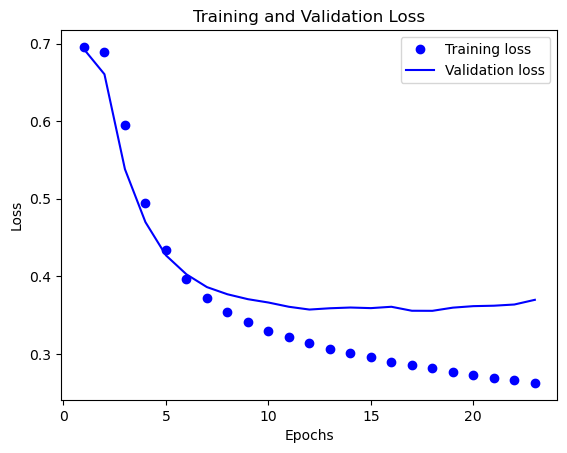

In [23]:
# 1_1 lstm random 임배딩 Loss 그래프

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('1_1 LSTM Random Embedding Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

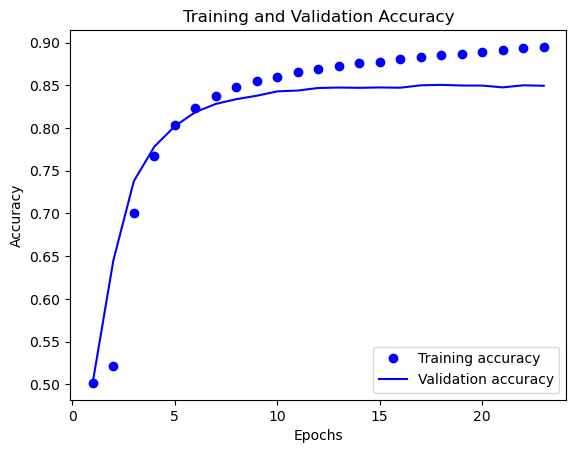

In [24]:
# 1_1 lstm random 임배딩 Accuracy 그래프

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('1_1 LSTM Random Embedding Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 5) 1_2 lstm word2vec 임배딩 사용한 실험

In [25]:
# 한국어 Word2vec 임베딩 활용하여 성능 개선

In [29]:
# 미리 학습된 Word2Vec 모델의 단어 벡터로 임베딩 행렬 초기화

import os
from gensim.models import Word2Vec

# 경로를 환경 변수와 결합하여 전체 경로를 만듭니다.
word2vec_file_path = os.path.join(os.getenv('HOME'), 'work/sentiment_classification/data/word2vec_ko.model')

# load() 함수를 사용하여 한국어 Word2Vec 모델 불러오기
try:
    word2vec_ko = Word2Vec.load(word2vec_file_path)
    print("한국어 Word2Vec 모델을 성공적으로 로드했습니다.")

    # .wv를 붙여서 활용
    vector = word2vec_ko.wv['사랑']
    print(f"'사랑' 단어의 벡터 차원: {vector.shape}")
    print(f"'사랑'과 유사한 단어: {word2vec_ko.wv.similar_by_word('사랑')}")

except FileNotFoundError:
    print(f"오류: {word2vec_file_path} 경로에 파일이 존재하지 않습니다.")
except Exception as e:
    print(f"모델 로드 중 오류가 발생했습니다: {e}")
# 전체 워드 벡터의 차원 확인
print(f"전체 워드 벡터의 shape: {word2vec_ko.wv.vectors.shape}")

한국어 Word2Vec 모델을 성공적으로 로드했습니다.
'사랑' 단어의 벡터 차원: (100,)
'사랑'과 유사한 단어: [('이별', 0.7626414895057678), ('행복', 0.7550068497657776), ('슬픔', 0.7381505966186523), ('유혹', 0.7238055467605591), ('그리움', 0.7167419195175171), ('추억', 0.7143999338150024), ('꿈', 0.7089294195175171), ('애정', 0.7066588997840881), ('포옹', 0.7034594416618347), ('마음', 0.6972615718841553)]
전체 워드 벡터의 shape: (302960, 100)


In [83]:
# Word2Vec 모델의 워드 벡터를 embedding_matrix에 복사

vocab_size = 10000  # 모델이 사용할 총 단어의 개수
#word_vector_dim = 100  # 워드 벡터의 차원 

# Word2Vec 모델의 벡터 차원 확인
word_vector_dim = word2vec_ko.wv.vector_size  # Word2Vec 모델의 실제 차원을 사용
print(f"Word2Vec 모델의 워드 벡터 차원: {word_vector_dim}")

# embedding_matrix를 np.random.rand()로 랜덤 초기화
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# Word2Vec에 있는 단어만 벡터를 덮어씀
for i in range(4, vocab_size):
    word = index_to_word[i]
    if word in word2vec_ko.wv:
        embedding_matrix[i] = word2vec_ko.wv[word]

print(f"새롭게 초기화된 embedding_matrix의 차원: {embedding_matrix.shape}")

Word2Vec 모델의 워드 벡터 차원: 100
새롭게 초기화된 embedding_matrix의 차원: (10000, 100)


In [84]:
# 5.1) 1_2 LSTM 모델 및 word2vec 임베딩 이용한 모델 구성

In [85]:
# 1_2 LSTM 모델 정의 및 구조 출력
import torch  # 딥러닝 프레임워크 PyTorch 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수 모음

vocab_size = 10000  # 모델이 다룰 수 있는 단어의 총 개수
word_vector_dim = 100  # 각 단어를 표현하는 워드 벡터의 차원

# 모델 설계: nn.Module을 상속받아 SentimentModel 클래스 정의
class SentimentModel(nn.Module):
    # 모델의 레이어(Layer)들을 정의
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어를 워드 벡터로 변환하는 임베딩 레이어
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)  # 워드 벡터 시퀀스를 처리하는 LSTM 레이어
        self.fc1 = nn.Linear(8, 8)  # LSTM의 최종 출력을 받아서 처리하는 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력을 0과 1 사이의 값으로 만드는 두 번째 완전 연결 레이어

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 임베딩 레이어에 통과시켜 워드 벡터로 변환
        x, (hn, cn) = self.lstm(x)  # 임베딩 벡터 시퀀스를 LSTM에 통과
        x = x[:, -1, :]  # LSTM의 최종 시점(sequence의 마지막)의 은닉 상태를 가져옴
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 레이어에 통과시키고 ReLU 활성화 함수 적용
        x = torch.sigmoid(self.fc2(x))  # 두 번째 완전 연결 레이어에 통과시키고 시그모이드 활성화 함수 적용 (0~1 사이 값)
        return x  # 최종 출력값 반환

model_lstm_word2vec = SentimentModel(vocab_size, word_vector_dim)  # 정의된 클래스를 바탕으로 모델 객체 생성
print(model_lstm_word2vec)  # 모델의 레이어 구조와 파라미터 정보 출력

SentimentModel(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [86]:
# 5.2) 1_2 LSTM 모델 및 word2vec 임베딩 훈련 개시

In [87]:
# PyTorch를 이용한 감성 분석 모델 훈련
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티

#모델 임베딩 초기화로 Word2vec 임베딩 매트릭스 적용
model_lstm_word2vec.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))


optimizer = optim.Adam(model_lstm_word2vec.parameters())  # 모델의 파라미터를 업데이트할 Adam 최적화 도구 설정
loss_fn = torch.nn.BCELoss()  # 이진 분류에 적합한 Binary Cross Entropy 손실 함수 설정

partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)  # 훈련용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)  # 훈련용 라벨 데이터를 PyTorch 텐서로 변환 (BCELoss를 위해 float 타입 사용)

X_val_tensor = X_val.detach().clone().to(torch.long)  # 검증용 입력 텐서를 복사하고 데이터 타입을 long으로 변환
y_val_tensor = torch.tensor(y_val, dtype=torch.float)  # 검증용 라벨 데이터를 PyTorch 텐서로 변환

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)  # 훈련 데이터와 라벨을 묶어 데이터셋 생성
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)  # 검증 데이터와 라벨을 묶어 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # 훈련용 데이터로더 생성 (배치 크기 512, 데이터 섞기)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)  # 검증용 데이터로더 생성 (배치 크기 512, 데이터 섞지 않음)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []  # 에포크별 검증 손실을 저장할 리스트
train_accs = []  # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []  # 에포크별 검증 정확도를 저장할 리스트

# 조기 종료 관련 하이퍼파라미터
patience = 5          # 검증 손실이 5번 연속으로 개선되지 않으면 훈련 중단
min_delta = 0.0001    # 최소한 이 값 이상 손실이 감소해야 개선으로 인정

best_loss = np.Inf    # 초기 최저 손실값 설정
patience_counter = 0  # 손실 개선 실패 횟수 카운터

for epoch in range(epochs):
    # 훈련 단계 시작
    model_lstm_word2vec.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0  # 현재 에포크의 누적 손실 초기화
    correct = 0  # 현재 에포크의 정답 수 초기화
    total = 0  # 현재 에포크의 전체 데이터 수 초기화

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화

        outputs = model_lstm_word2vec(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()  # 현재 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
        total += labels.size(0)  # 전체 데이터 수 누적

    train_losses.append(running_loss / len(train_loader))  # 에포크별 평균 훈련 손실 기록
    train_accs.append(correct / total)  # 에포크별 훈련 정확도 기록

    # 검증 단계 시작
    model_lstm_word2vec.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0  # 현재 에포크의 누적 검증 손실 초기화
    val_correct = 0  # 현재 에포크의 정답 수 초기화
    val_total = 0  # 현재 에포크의 전체 데이터 수 초기화

    with torch.no_grad():  # 기울기 계산을 비활성화 (메모리 절약, 연산 속도 향상)
        for inputs, labels in val_loader:
            outputs = model_lstm_word2vec(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
            loss = loss_fn(outputs.squeeze(), labels)  # 손실 계산

            val_loss += loss.item()  # 현재 배치 손실을 누적
            predicted = (outputs.squeeze() > 0.5).float()  # 예측값 기반으로 정답 판단
            val_correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
            val_total += labels.size(0)  # 전체 데이터 수 누적

    val_losses.append(val_loss / len(val_loader))  # 에포크별 평균 검증 손실 기록
    val_accs.append(val_correct / val_total)  # 에포크별 검증 정확도 기록

    val_loss = val_losses[-1] # 현재 에포크의 검증 손실

    # 손실 개선 여부 확인
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        # 최적의 모델 가중치 저장
        torch.save(model_lstm_word2vec.state_dict(), 'model_lstm_word2vec.pth')
        print(f"Validation loss improved. Saving model weights...")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    # 조기 종료 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
    
    # 에포크별 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - "
          f"T_Loss: {train_losses[-1]:.4f}, T_Acc: {train_accs[-1]:.4f} - "
          f"V_Loss: {val_losses[-1]:.4f}, V_Acc: {val_accs[-1]:.4f}")

Validation loss improved. Saving model weights...
Epoch 1/30 - T_Loss: 0.6961, T_Acc: 0.4991 - V_Loss: 0.6933, V_Acc: 0.5022
Validation loss improved. Saving model weights...
Epoch 2/30 - T_Loss: 0.6924, T_Acc: 0.5046 - V_Loss: 0.6925, V_Acc: 0.5082
Validation loss improved. Saving model weights...
Epoch 3/30 - T_Loss: 0.6633, T_Acc: 0.5665 - V_Loss: 0.5486, V_Acc: 0.7327
Validation loss improved. Saving model weights...
Epoch 4/30 - T_Loss: 0.4624, T_Acc: 0.7921 - V_Loss: 0.4320, V_Acc: 0.8104
Validation loss improved. Saving model weights...
Epoch 5/30 - T_Loss: 0.3958, T_Acc: 0.8299 - V_Loss: 0.4079, V_Acc: 0.8231
Validation loss improved. Saving model weights...
Epoch 6/30 - T_Loss: 0.3629, T_Acc: 0.8471 - V_Loss: 0.3915, V_Acc: 0.8298
Validation loss improved. Saving model weights...
Epoch 7/30 - T_Loss: 0.3436, T_Acc: 0.8577 - V_Loss: 0.3881, V_Acc: 0.8313
Validation loss improved. Saving model weights...
Epoch 8/30 - T_Loss: 0.3302, T_Acc: 0.8645 - V_Loss: 0.3832, V_Acc: 0.8365


In [88]:
# 1_2 lstm word2vec 임배딩 파일 저장

word2vec_file_path = 'model_lstm_word2vec.txt'

# 모델의 임베딩 가중치와 단어-인덱스 매핑 준비
# 1. 모델 변수명을 'model_lstm_cnn_word2vec'로 수정
vectors = model_lstm_word2vec.embedding.weight.detach().cpu().numpy()

# 2. 모델 훈련 시 사용했던 실제 'word_to_index' 딕셔너리를 활용하여
#    'index_to_word' 딕셔너리를 생성합니다.
#    (이 부분은 실제 훈련 코드에 있는 'word_to_index' 변수명으로 교체해야 합니다.)
#    예시: word_to_index = {'<pad>': 0, '<unk>': 1, '영화': 2, ...}
#    - word_to_index 변수가 없으면 이 코드는 에러를 발생시킵니다.
index_to_word = {index: word for word, index in word_to_index.items()}


# 파일에 쓰기
with open(word2vec_file_path, 'w') as f:
    # 1. 파일의 첫 줄에 '전체 단어 수', '벡터 차원'을 기록합니다.
    #    gensim이 이 정보를 보고 파일 형식을 판단합니다.
    vocab_size, word_vector_dim = vectors.shape
    f.write(f'{vocab_size} {word_vector_dim}\n')
    
    # 2. 각 단어의 벡터 값을 공백으로 구분하여 한 줄씩 기록합니다.
    for i in range(vocab_size):
        # 3. index_to_word.get(i, '<unk>')를 사용하여 없는 인덱스도 안전하게 처리
        word = index_to_word.get(i, '<unk>')
        vector_str = ' '.join(map(str, vectors[i, :]))
        f.write(f'{word} {vector_str}\n')

print(f"'{word2vec_file_path}' 파일에 임베딩 가중치가 저장되었습니다.")

'model_lstm_word2vec.txt' 파일에 임베딩 가중치가 저장되었습니다.


In [89]:
# 1_2 lstm word2vec Embedding 훈련 모델 테스트 

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_lstm_word2vec.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm_word2vec(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.4063, Test Accuracy: 0.8365


In [90]:
# 5.3) 1_2 lstm word2vec 임배딩 Loss, Acuraccy 그래프 시각화

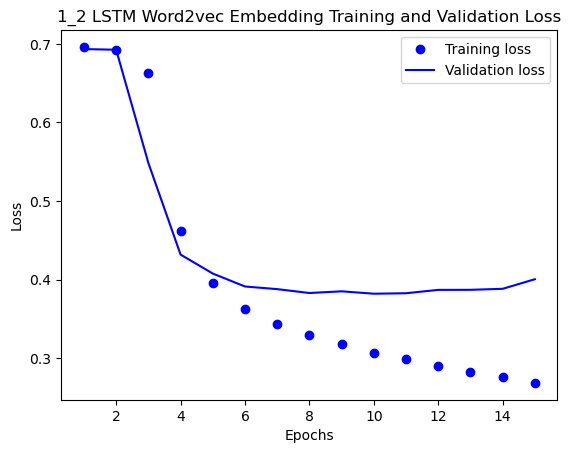

In [91]:
# 1_2 lstm word2vec 임배딩 Loss

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('1_2 LSTM Word2vec Embedding Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

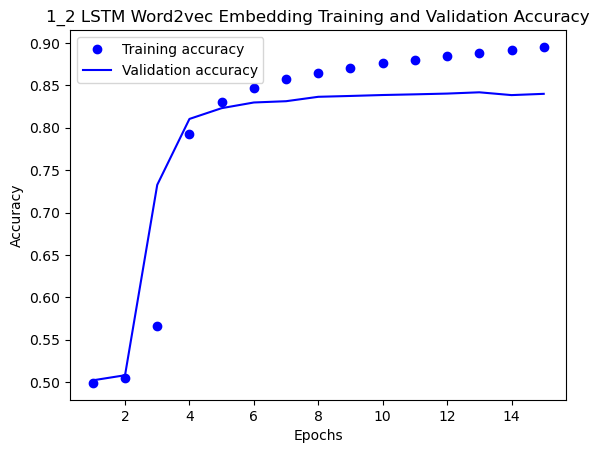

In [92]:
# 1_2 lstm word2vec Embedding 임배딩 Acuraccy

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('1_2 LSTM Word2vec Embedding Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 6) 2_1 CNN Random Embedding 실험

In [37]:
# 6.1) 2_1 CNN Random Embedding 모델 정의 

In [38]:
# 2_1 CNN Random Embedding (1D CNN) 모델 정의
import torch  # 딥러닝 프레임워크 PyTorch 라이브러리
from torch import nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수 모음 (시그모이드 함수를 위해 필요)

# SentenceClassifier_Cnn 클래스 정의 (nn.Module 상속)
class SentenceClassifier_Cnn(nn.Module):
    # 모델의 레이어(Layer)들을 정의하는 생성자
    def __init__(self, embedding_matrix, filter_sizes, max_length, dropout=0.5):
        super().__init__()  # nn.Module의 생성자 호출

        # 임베딩 레이어
        self.embedding = nn.Embedding(
            num_embeddings=embedding_matrix.shape[0],
            embedding_dim=embedding_matrix.shape[1]
        )
        # 외부에서 전달받은 행렬의 값을 임베딩 레이어의 가중치로 복사
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        # 임베딩 레이어의 차원(word_vector_dim) 추출
        embedding_dim = self.embedding.weight.shape[1]
        num_filters = 128  # out_channels 수를 128로 설정

        conv = []
        for size in filter_sizes:  # filter_sizes (예: [3, 4, 5])에 따라 여러 개의 CNN 필터를 만듦
            conv.append(
                nn.Sequential(  # 여러 레이어를 묶어서 하나의 모듈로 구성
                    nn.Conv1d(  # 1차원 컨볼루션 레이어
                        in_channels=embedding_dim,  # 입력 채널 수: 워드 벡터의 차원
                        out_channels=num_filters,  # 출력 채널 수: 각 필터에서 하나의 특징을 추출
                        kernel_size=size  # 필터의 크기 (ex: 3, 4, 5)
                    ),
                    nn.ReLU(),  # 비선형성을 추가하는 활성화 함수
                    nn.AdaptiveMaxPool1d(1),  # 최대 풀링으로 가장 중요한 특징 추출
                )
            )
        self.conv_filters = nn.ModuleList(conv)  # 여러 컨볼루션 모듈을 리스트 형태로 저장

        num_filters = 128
        output_size = num_filters * len(filter_sizes) # 128 * 3 = 384 # 필터의 개수가 최종 출력의 크기가 됨
        self.pre_classifier = nn.Linear(output_size, 64)  # 첫 번째 완전 연결 레이어
        self.dropout = nn.Dropout(dropout)  # 과적합을 방지하는 드롭아웃 레이어
        self.classifier = nn.Linear(64, 1)  # 최종 분류를 위한 완전 연결 레이어 (출력 1개)

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, inputs):
        embeddings = self.embedding(inputs)  # 입력(단어 인덱스)을 임베딩 레이어에 통과
        embeddings = embeddings.permute(0, 2, 1)  # Conv1d 입력에 맞게 차원 변경 (배치, 차원, 길이)

        conv_outputs = [conv(embeddings) for conv in self.conv_filters]  # 각 필터를 통과한 결과물을 리스트에 저장
        concat_outputs = torch.cat([conv.squeeze(-1) for conv in conv_outputs], dim=1)  # 필터 결과물을 하나로 합침

        logits = self.pre_classifier(concat_outputs)  # 첫 번째 완전 연결 레이어 통과
        logits = self.dropout(logits)  # 드롭아웃 적용
        logits = self.classifier(logits)  # 최종 분류 레이어 통과
        
        return torch.sigmoid(logits)  # 이진 분류를 위해 시그모이드 활성화 함수 적용

In [39]:
# 2_1 CNN Random Embedding 모델 인스턴스화를 위한 변수 설정

# 이전 LSTM 실험에서 사용한 값들을 기준으로 설정
vocab_size = 10000 
word_vector_dim = 16
max_length = 41  # 예시 값 (실제 데이터의 max_length로 대체 필요)

# 실험을 위한 랜덤 임베딩 행렬 생성
# Word2Vec을 사용하지 않고 랜덤 값으로 초기화
random_embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 1D CNN 모델 인스턴스화 (랜덤 임베딩 사용)
model_cnn_random = SentenceClassifier_Cnn(
    embedding_matrix=random_embedding_matrix, 
    filter_sizes=[2, 3, 4], # 예시: 다양한 크기의 필터 사용
    max_length=max_length,
    dropout=0.5
)

# 모델 구조 출력
print("첫 번째 모델 (랜덤 임베딩) 구조:")
print(model_cnn_random)

첫 번째 모델 (랜덤 임베딩) 구조:
SentenceClassifier_Cnn(
  (embedding): Embedding(10000, 16)
  (conv_filters): ModuleList(
    (0): Sequential(
      (0): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (1): Sequential(
      (0): Conv1d(16, 128, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (2): Sequential(
      (0): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (pre_classifier): Linear(in_features=384, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# 6.2) 2_1 CNN Random Embedding 모델 훈련

In [40]:
# 2_1 CNN Random Embedding 모델 훈련

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset



optimizer = optim.Adam(model_cnn_random.parameters())
loss_fn = torch.nn.BCELoss()

partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = X_val.detach().clone().to(torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 조기 종료 관련 하이퍼파라미터
patience = 5          # 검증 손실이 5번 연속으로 개선되지 않으면 훈련 중단
min_delta = 0.0001    # 최소한 이 값 이상 손실이 감소해야 개선으로 인정
best_loss = np.Inf    # 초기 최저 손실값 설정
patience_counter = 0  # 손실 개선 실패 횟수 카운터

for epoch in range(epochs):
    # 훈련 단계 시작
    model_cnn_random.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_cnn_random(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # 검증 단계 시작
    model_cnn_random.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_cnn_random(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    val_loss = val_losses[-1] # 현재 에포크의 검증 손실

    # 손실 개선 여부 확인
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        # 최적의 모델 가중치 저장
        torch.save(model_cnn_random.state_dict(), 'model_cnn_random.pth')
        print(f"Validation loss improved. Saving model weights...")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    # 조기 종료 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


        
    print(f"Epoch {epoch+1}/{epochs} - "
          f"T_Loss: {train_losses[-1]:.4f}, T_Acc: {train_accs[-1]:.4f} - "
          f"V_Loss: {val_losses[-1]:.4f}, V_Acc: {val_accs[-1]:.4f}")


Validation loss improved. Saving model weights...
Epoch 1/30 - T_Loss: 0.5501, T_Acc: 0.7011 - V_Loss: 0.4117, V_Acc: 0.8084
Validation loss improved. Saving model weights...
Epoch 2/30 - T_Loss: 0.3802, T_Acc: 0.8305 - V_Loss: 0.3580, V_Acc: 0.8389
Validation loss improved. Saving model weights...
Epoch 3/30 - T_Loss: 0.3363, T_Acc: 0.8551 - V_Loss: 0.3429, V_Acc: 0.8489
Validation loss improved. Saving model weights...
Epoch 4/30 - T_Loss: 0.3115, T_Acc: 0.8682 - V_Loss: 0.3392, V_Acc: 0.8503
Validation loss improved. Saving model weights...
Epoch 5/30 - T_Loss: 0.2919, T_Acc: 0.8783 - V_Loss: 0.3372, V_Acc: 0.8571
Validation loss did not improve. Patience counter: 1/5
Epoch 6/30 - T_Loss: 0.2754, T_Acc: 0.8863 - V_Loss: 0.3395, V_Acc: 0.8550
Validation loss did not improve. Patience counter: 2/5
Epoch 7/30 - T_Loss: 0.2592, T_Acc: 0.8947 - V_Loss: 0.3558, V_Acc: 0.8527
Validation loss did not improve. Patience counter: 3/5
Epoch 8/30 - T_Loss: 0.2448, T_Acc: 0.9022 - V_Loss: 0.3773,

In [41]:
# 2_1 CNN Random Embedding 파일 경로
word2vec_file_path = 'model_cnn_random.txt'

# 모델의 임베딩 가중치와 단어-인덱스 매핑 준비
# 1. 모델 변수명을 'model_lstm_cnn_word2vec'로 수정
vectors = model_cnn_random.embedding.weight.detach().cpu().numpy()

# 2. 모델 훈련 시 사용했던 실제 'word_to_index' 딕셔너리를 활용하여
#    'index_to_word' 딕셔너리를 생성합니다.
#    (이 부분은 실제 훈련 코드에 있는 'word_to_index' 변수명으로 교체해야 합니다.)
#    예시: word_to_index = {'<pad>': 0, '<unk>': 1, '영화': 2, ...}
#    - word_to_index 변수가 없으면 이 코드는 에러를 발생시킵니다.
index_to_word = {index: word for word, index in word_to_index.items()}


# 파일에 쓰기
with open(word2vec_file_path, 'w') as f:
    # 1. 파일의 첫 줄에 '전체 단어 수', '벡터 차원'을 기록합니다.
    #    gensim이 이 정보를 보고 파일 형식을 판단합니다.
    vocab_size, word_vector_dim = vectors.shape
    f.write(f'{vocab_size} {word_vector_dim}\n')
    
    # 2. 각 단어의 벡터 값을 공백으로 구분하여 한 줄씩 기록합니다.
    for i in range(vocab_size):
        # 3. index_to_word.get(i, '<unk>')를 사용하여 없는 인덱스도 안전하게 처리
        word = index_to_word.get(i, '<unk>')
        vector_str = ' '.join(map(str, vectors[i, :]))
        f.write(f'{word} {vector_str}\n')

print(f"'{word2vec_file_path}' 파일에 임베딩 가중치가 저장되었습니다.")

'model_cnn_random.txt' 파일에 임베딩 가중치가 저장되었습니다.


In [42]:
# 2_1 CNN Random Embedding 훈련 모델 테스트

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_cnn_random.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_cnn_random(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3819, Test Accuracy: 0.8484


In [ ]:
# 6.3) 2_1 CNN Random Embedding Loss, Accuracy 그래프 시각화

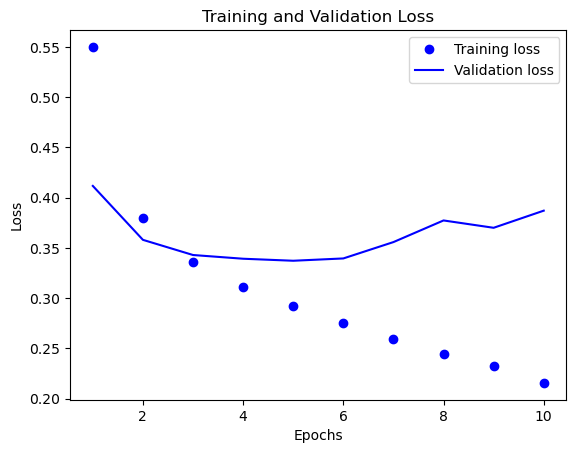

In [43]:
# 2_1 CNN Random Embedding Loss 시각화

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

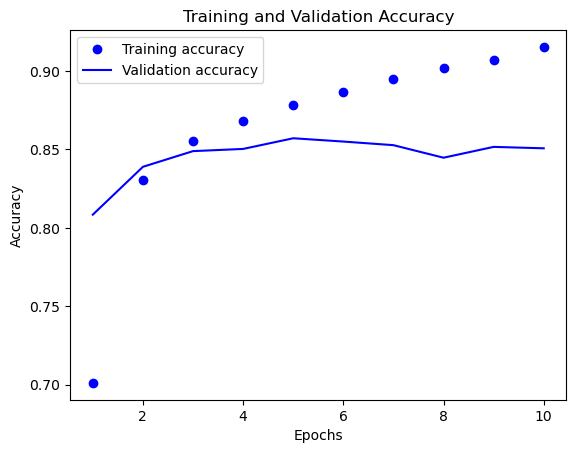

In [44]:
# 2_1 CNN Random Embedding Accuracy 시각화

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 7) 2_2 CNN word2vec Embedding 모델 실험

In [ ]:
# 7.1) 2_2 CNN word2vec Embedding 변수 설정

In [45]:
# 2_2 CNN word2vec모델 인스턴스화를 위한 변수 설정


# Word2Vec 모델의 차원에 맞춰 word_vector_dim을 100으로 설정
vocab_size = 10000 
word_vector_dim = 100
max_length = 41  # pad_sequences의 maxlen 값 사용

# 1. Word2Vec 모델 로드 및 임베딩 행렬 생성
word2vec_file_path = os.path.join(os.getenv('HOME'), 'work/sentiment_classification/data/word2vec_ko.model')
word2vec_ko = Word2Vec.load(word2vec_file_path)


# Word2Vec으로 채워진 임베딩 행렬 생성
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec_ko.wv:
        embedding_matrix[i] = word2vec_ko.wv[index_to_word[i]]

# 2. 1D CNN 모델 인스턴스화 (Word2Vec 임베딩 사용)
# SentenceClassifier_Cnn 클래스는 이미 정의되어 있다고 가정
model_cnn_word2vec = SentenceClassifier_Cnn(
    embedding_matrix=embedding_matrix, 
    filter_sizes=[2, 3, 4],
    max_length=max_length,
    dropout=0.5
)

# 모델 구조 출력 (확인용)
print("--- cnn 2: Word2Vec 임베딩 행렬 사용 ---")
print(model_cnn_word2vec)

--- cnn 2: Word2Vec 임베딩 행렬 사용 ---
SentenceClassifier_Cnn(
  (embedding): Embedding(10000, 100)
  (conv_filters): ModuleList(
    (0): Sequential(
      (0): Conv1d(100, 128, kernel_size=(2,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (1): Sequential(
      (0): Conv1d(100, 128, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
    (2): Sequential(
      (0): Conv1d(100, 128, kernel_size=(4,), stride=(1,))
      (1): ReLU()
      (2): AdaptiveMaxPool1d(output_size=1)
    )
  )
  (pre_classifier): Linear(in_features=384, out_features=64, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# 7.2) 2_2 CNN word2vec Embedding 모델 학습

In [46]:
# 2_2 1D CNN word2vec 모델 훈련

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# 이 코드는 Word2Vec 임베딩 행렬로 모델을 초기화하는 부분입니다.
# cnn 2 실험에 필수적이므로 그대로 유지해야 합니다.
# model_cnn_word2vec.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

# model 변수에는 'model_cnn_word2ve' 객체가 할당되어 있다고 가정
# optimizer를 정의할 때 이 모델을 사용해야 합니다.
# --- 이 부분을 수정해야 합니다. ---
optimizer = optim.Adam(model_cnn_word2vec.parameters())
loss_fn = torch.nn.BCELoss()

partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = X_val.detach().clone().to(torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 조기 종료 관련 하이퍼파라미터
patience = 5          # 검증 손실이 5번 연속으로 개선되지 않으면 훈련 중단
min_delta = 0.0001    # 최소한 이 값 이상 손실이 감소해야 개선으로 인정
best_loss = np.Inf    # 초기 최저 손실값 설정
patience_counter = 0  # 손실 개선 실패 횟수 카운터

for epoch in range(epochs):
    # 훈련 단계 시작
    # --- 이 부분도 수정해야 합니다. ---
    model_cnn_word2vec.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # --- 이 부분도 수정해야 합니다. ---
        outputs = model_cnn_word2vec(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # 검증 단계 시작
    model_cnn_word2vec.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_cnn_word2vec(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    val_loss = val_losses[-1] # 현재 에포크의 검증 손실

    # 손실 개선 여부 확인
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        # 최적의 모델 가중치 저장
        torch.save(model_cnn_word2vec.state_dict(), 'model_cnn_word2vec.pth')
        print(f"Validation loss improved. Saving model weights...")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    # 조기 종료 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    
    print(f"Epoch {epoch+1}/{epochs} - "
          f"T_Loss: {train_losses[-1]:.4f}, T_Acc: {train_accs[-1]:.4f} - "
          f"V_Loss: {val_losses[-1]:.4f}, V_Acc: {val_accs[-1]:.4f}")

Validation loss improved. Saving model weights...
Epoch 1/30 - T_Loss: 0.5302, T_Acc: 0.7362 - V_Loss: 0.4216, V_Acc: 0.8071
Validation loss improved. Saving model weights...
Epoch 2/30 - T_Loss: 0.3888, T_Acc: 0.8266 - V_Loss: 0.3586, V_Acc: 0.8412
Validation loss improved. Saving model weights...
Epoch 3/30 - T_Loss: 0.3293, T_Acc: 0.8575 - V_Loss: 0.3543, V_Acc: 0.8426
Validation loss improved. Saving model weights...
Epoch 4/30 - T_Loss: 0.2937, T_Acc: 0.8768 - V_Loss: 0.3330, V_Acc: 0.8584
Validation loss improved. Saving model weights...
Epoch 5/30 - T_Loss: 0.2645, T_Acc: 0.8912 - V_Loss: 0.3314, V_Acc: 0.8583
Validation loss did not improve. Patience counter: 1/5
Epoch 6/30 - T_Loss: 0.2385, T_Acc: 0.9035 - V_Loss: 0.3434, V_Acc: 0.8582
Validation loss did not improve. Patience counter: 2/5
Epoch 7/30 - T_Loss: 0.2148, T_Acc: 0.9139 - V_Loss: 0.3615, V_Acc: 0.8561
Validation loss did not improve. Patience counter: 3/5
Epoch 8/30 - T_Loss: 0.1924, T_Acc: 0.9238 - V_Loss: 0.3731,

In [47]:
# 2_2 CNN word2vec Embedding 파일 저장

word2vec_file_path = 'model_cnn_word2vec.txt'

# 모델의 임베딩 가중치와 단어-인덱스 매핑 준비
# 1. 모델 변수명을 'model_lstm_cnn_word2vec'로 수정
vectors = model_cnn_word2vec.embedding.weight.detach().cpu().numpy()

# 2. 모델 훈련 시 사용했던 실제 'word_to_index' 딕셔너리를 활용하여
#    'index_to_word' 딕셔너리를 생성합니다.
#    (이 부분은 실제 훈련 코드에 있는 'word_to_index' 변수명으로 교체해야 합니다.)
#    예시: word_to_index = {'<pad>': 0, '<unk>': 1, '영화': 2, ...}
#    - word_to_index 변수가 없으면 이 코드는 에러를 발생시킵니다.
index_to_word = {index: word for word, index in word_to_index.items()}


# 파일에 쓰기
with open(word2vec_file_path, 'w') as f:
    # 1. 파일의 첫 줄에 '전체 단어 수', '벡터 차원'을 기록합니다.
    #    gensim이 이 정보를 보고 파일 형식을 판단합니다.
    vocab_size, word_vector_dim = vectors.shape
    f.write(f'{vocab_size} {word_vector_dim}\n')
    
    # 2. 각 단어의 벡터 값을 공백으로 구분하여 한 줄씩 기록합니다.
    for i in range(vocab_size):
        # 3. index_to_word.get(i, '<unk>')를 사용하여 없는 인덱스도 안전하게 처리
        word = index_to_word.get(i, '<unk>')
        vector_str = ' '.join(map(str, vectors[i, :]))
        f.write(f'{word} {vector_str}\n')

print(f"'{word2vec_file_path}' 파일에 임베딩 가중치가 저장되었습니다.")

'model_cnn_word2vec.txt' 파일에 임베딩 가중치가 저장되었습니다.


In [48]:
# 2_2 CNN word2vec Embedding 학습한 모델 테스트

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_cnn_word2vec.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_cnn_word2vec(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.4539, Test Accuracy: 0.8480


In [ ]:
# 7.3) 2_2 CNN word2vec Embedding Loss, Accuracy 그래프 시각화

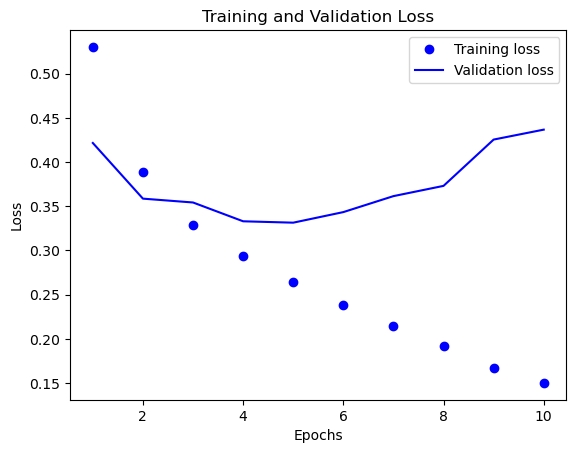

In [49]:
# 2_2 CNN word2vec Embedding Loss 시각화

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('2_2 CNN Word2vec Embedding Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

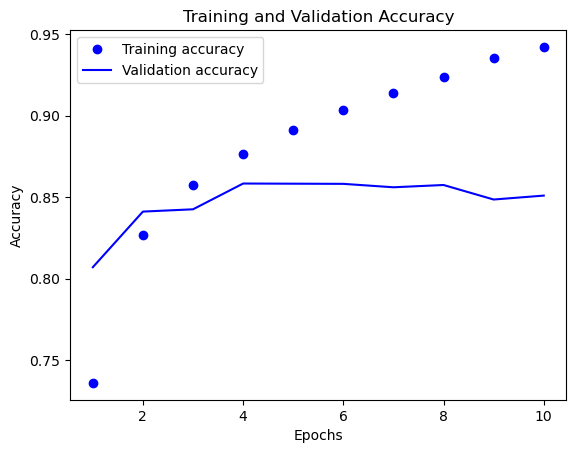

In [50]:
# 2_2 CNN word2vec Embedding Accuracy시각화

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('2_2 CNN Word2vec Embedding Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 8) 3_1 LSTM_CNN Random Embedding 모델 실험

In [ ]:
# 8.1) 3_1 LSTM_CNN Random Embedding 모델 정의 

In [52]:
#  3_1 LSTM_CNN Random Embedding 모델 정의
 # LSTM과 CNN 모델을 합쳐서 사용

import torch
from torch import nn
import torch.nn.functional as F

class SentenceClassifier_LstmCnn(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout, bidirectional, filter_sizes, max_length):
        super().__init__()

        # 1. 임베딩 레이어: 단어를 벡터로 변환
        self.embedding = nn.Embedding(
            num_embeddings=embedding_matrix.shape[0],
            embedding_dim=embedding_matrix.shape[1]
        )
        
          # 외부에서 전달받은 행렬의 값을 임베딩 레이어의 가중치로 복사
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        embedding_dim = self.embedding.weight.shape[1]
        # self.embedding.weight.requires_grad = True

        # 2. LSTM 레이어: 문장의 순차적인 흐름과 맥락을 학습
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True  # 입력 텐서의 첫 번째 차원이 배치 크기임을 명시
        )
        
        # LSTM의 출력 차원을 계산
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        num_filters = 128  # out_channels 수를 128로 설정
        
        # 3. CNN 필터들: LSTM 출력에서 특징을 추출
        conv = []
        for size in filter_sizes:
            conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=lstm_output_dim,  # LSTM의 출력을 입력으로 사용
                        out_channels=num_filters,
                        kernel_size=size
                    ),
                    nn.ReLU(),
                    nn.AdaptiveMaxPool1d(1),
                )
            )
        self.conv_filters = nn.ModuleList(conv)
        
        # 4. 분류기 레이어: 추출된 특징으로 최종 분류
        output_size = num_filters * len(filter_sizes) # 128 * 3 = 384

        self.pre_classifier = nn.Linear(output_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(64, 1)

    def forward(self, inputs):
        # (1) 임베딩 레이어 통과
        embeddings = self.embedding(inputs)  # [배치, 시퀀스 길이, 임베딩 차원]

        # (2) LSTM 레이어 통과
        lstm_output, (hidden, cell) = self.lstm(embeddings)
        # lstm_output: [배치, 시퀀스 길이, hidden_dim * 2 (양방향인 경우)]

        # (3) CNN 레이어 입력에 맞게 차원 변경
        # Conv1d를 위해 [배치, 채널 수, 시퀀스 길이] 형태로 변경
        lstm_output = lstm_output.permute(0, 2, 1)

        # (4) CNN 필터들 통과
        conv_outputs = [conv(lstm_output) for conv in self.conv_filters]
        concat_outputs = torch.cat([conv.squeeze(-1) for conv in conv_outputs], dim=1)

        # (5) 분류기 통과
        logits = self.pre_classifier(concat_outputs)
        logits = self.dropout(logits)
        logits = self.classifier(logits)

        # 최종 시그모이드 활성화 함수 적용
        return torch.sigmoid(logits)

In [ ]:
# 7.2) 3_1 LSTM_CNN Random Embedding 모델 학습

In [53]:
#  3_1 LSTM_CNN Random Embedding 모델 학습

import torch
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티
import numpy as np
# from SentenceClassifier_LstmCnn import SentenceClassifier_LstmCnn  # 모델 클래스 import
from tqdm import tqdm  # tqdm 라이브러리 import
import numpy as np

# 조기 종료 관련 하이퍼파라미터
patience = 5          # 검증 손실이 5번 연속으로 개선되지 않으면 훈련 중단
min_delta = 0.0001    # 최소한 이 값 이상 손실이 감소해야 개선으로 인정

best_loss = np.Inf    # 초기 최저 손실값 설정
patience_counter = 0  # 손실 개선 실패 횟수 카운터


# 모델 인스턴스화를 위한 변수 설정
# 이전 실험들과 일관성을 유지하거나 새로운 하이퍼파라미터를 설정한다.
vocab_size = 10000 
word_vector_dim = 16  # Word2Vec 임베딩을 위해 100으로 설정 (랜덤 실험 시에는 16)
max_length = 41
hidden_dim = 128  # LSTM의 은닉 상태 차원
num_layers = 2   # LSTM 레이어 수
dropout = 0.5  # 드롭아웃 확률
bidirectional = True # LSTM 양방향 설정
filter_sizes = [2, 3, 4] # CNN 필터 크기

# Word2Vec 임베딩 행렬을 사용한다고 가정하고, 이를 생성
# (실제 Word2Vec 모델 로드 및 임베딩 행렬 생성 코드는 이전에 수행되었어야 함)
# embedding_matrix = ...
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)


# 모델 인스턴스화
model_lstm_cnn_random = SentenceClassifier_LstmCnn(
    embedding_matrix=embedding_matrix,  
    hidden_dim=hidden_dim,  
    num_layers=num_layers,  
    dropout=dropout,  
    bidirectional=bidirectional,  
    filter_sizes=filter_sizes,  
    max_length=max_length
)

# 1. 모델 임베딩 초기화 (Word2Vec 사용 시)
# 모델의 임베딩 레이어를 사전 학습된 Word2Vec 벡터로 덮어씌운다.
# 랜덤 임베딩을 사용하는 실험에서는 이 줄을 주석 처리해야 한다.
#model_lstm_cnn_random.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

# 2. 옵티마이저와 손실 함수 설정
# Adam 최적화 도구와 이진 분류에 적합한 BCELoss 손실 함수를 사용한다.
optimizer = optim.Adam(model_lstm_cnn_random.parameters())
loss_fn = torch.nn.BCELoss()

# 3. 데이터 로더 준비
# 훈련 및 검증 데이터를 텐서로 변환하고 데이터셋, 데이터로더를 생성한다.
partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = X_val.detach().clone().to(torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []    # 에포크별 검증 손실을 저장할 리스트
train_accs = []    # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []      # 에포크별 검증 정확도를 저장할 리스트

# 4. 모델 훈련 및 검증 루프
for epoch in range(epochs):
    # 훈련 단계 시작
    model_lstm_cnn_random.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화
        outputs = model_lstm_cnn_random(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # 검증 단계 시작
    model_lstm_cnn_random.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    

    with torch.no_grad():  # 기울기 계산 비활성화 (메모리 절약, 속도 향상)
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            outputs = model_lstm_cnn_random(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    val_loss = val_losses[-1] # 현재 에포크의 검증 손실

    # 손실 개선 여부 확인
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        # 최적의 모델 가중치 저장
        torch.save(model_lstm_cnn_random.state_dict(), 'model_lstm_cnn_random.pth')
        print(f"Validation loss improved. Saving model weights...")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    # 조기 종료 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


    
    # 에포크별 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - "
          f"T_Loss: {train_losses[-1]:.4f}, T_Acc: {train_accs[-1]:.4f} - "
          f"V_Loss: {val_losses[-1]:.4f}, V_Acc: {val_accs[-1]:.4f}")

Epoch 1/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Validation loss improved. Saving model weights...
Epoch 1/30 - T_Loss: 0.5458, T_Acc: 0.7027 - V_Loss: 0.4098, V_Acc: 0.8109


Epoch 2/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Validation loss improved. Saving model weights...
Epoch 2/30 - T_Loss: 0.3851, T_Acc: 0.8291 - V_Loss: 0.3620, V_Acc: 0.8375


Epoch 3/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Validation loss improved. Saving model weights...
Epoch 3/30 - T_Loss: 0.3449, T_Acc: 0.8515 - V_Loss: 0.3530, V_Acc: 0.8438


Epoch 4/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Validation loss improved. Saving model weights...
Epoch 4/30 - T_Loss: 0.3289, T_Acc: 0.8602 - V_Loss: 0.3391, V_Acc: 0.8506


Epoch 5/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


Validation loss did not improve. Patience counter: 1/5
Epoch 5/30 - T_Loss: 0.3152, T_Acc: 0.8672 - V_Loss: 0.3453, V_Acc: 0.8487


Epoch 6/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


Validation loss did not improve. Patience counter: 2/5
Epoch 6/30 - T_Loss: 0.3059, T_Acc: 0.8715 - V_Loss: 0.3421, V_Acc: 0.8500


Epoch 7/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Validation loss improved. Saving model weights...
Epoch 7/30 - T_Loss: 0.2976, T_Acc: 0.8756 - V_Loss: 0.3331, V_Acc: 0.8568


Epoch 8/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Validation loss improved. Saving model weights...
Epoch 8/30 - T_Loss: 0.2888, T_Acc: 0.8795 - V_Loss: 0.3305, V_Acc: 0.8556


Epoch 9/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation loss did not improve. Patience counter: 1/5
Epoch 9/30 - T_Loss: 0.2821, T_Acc: 0.8832 - V_Loss: 0.3449, V_Acc: 0.8535


Epoch 10/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Validation loss did not improve. Patience counter: 2/5
Epoch 10/30 - T_Loss: 0.2763, T_Acc: 0.8859 - V_Loss: 0.3340, V_Acc: 0.8571


Epoch 11/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Validation loss did not improve. Patience counter: 3/5
Epoch 11/30 - T_Loss: 0.2701, T_Acc: 0.8891 - V_Loss: 0.3406, V_Acc: 0.8565


Epoch 12/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation loss did not improve. Patience counter: 4/5
Epoch 12/30 - T_Loss: 0.2651, T_Acc: 0.8911 - V_Loss: 0.3312, V_Acc: 0.8578


Epoch 13/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]

Validation loss did not improve. Patience counter: 5/5
Early stopping triggered after 13 epochs.


In [54]:
#  3_1 LSTM_CNN Random Embedding 파일 저장
word2vec_file_path = 'model_lstm_cnn_random.txt'

# 모델의 임베딩 가중치와 단어-인덱스 매핑 준비
# 1. 모델 변수명을 'model_lstm_cnn_word2vec'로 수정
vectors = model_lstm_cnn_random.embedding.weight.detach().cpu().numpy()

# 2. 모델 훈련 시 사용했던 실제 'word_to_index' 딕셔너리를 활용하여
#    'index_to_word' 딕셔너리를 생성합니다.
#    (이 부분은 실제 훈련 코드에 있는 'word_to_index' 변수명으로 교체해야 합니다.)
#    예시: word_to_index = {'<pad>': 0, '<unk>': 1, '영화': 2, ...}
#    - word_to_index 변수가 없으면 이 코드는 에러를 발생시킵니다.
index_to_word = {index: word for word, index in word_to_index.items()}


# 파일에 쓰기
with open(word2vec_file_path, 'w') as f:
    # 1. 파일의 첫 줄에 '전체 단어 수', '벡터 차원'을 기록합니다.
    #    gensim이 이 정보를 보고 파일 형식을 판단합니다.
    vocab_size, word_vector_dim = vectors.shape
    f.write(f'{vocab_size} {word_vector_dim}\n')
    
    # 2. 각 단어의 벡터 값을 공백으로 구분하여 한 줄씩 기록합니다.
    for i in range(vocab_size):
        # 3. index_to_word.get(i, '<unk>')를 사용하여 없는 인덱스도 안전하게 처리
        word = index_to_word.get(i, '<unk>')
        vector_str = ' '.join(map(str, vectors[i, :]))
        f.write(f'{word} {vector_str}\n')

print(f"'{word2vec_file_path}' 파일에 임베딩 가중치가 저장되었습니다.")

'model_lstm_cnn_random.txt' 파일에 임베딩 가중치가 저장되었습니다.


In [55]:
#  3_1 LSTM_CNN Random Embedding 학습된 모델 테스트

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_lstm_cnn_random.load_state_dict(torch.load('model_lstm_cnn_random.pth'))
model_lstm_cnn_random.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm_cnn_random(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3396, Test Accuracy: 0.8540


In [ ]:
# 8.3)  3_1 LSTM_CNN Random Embedding 모델 Loss, Accuracy 그래프 시각화

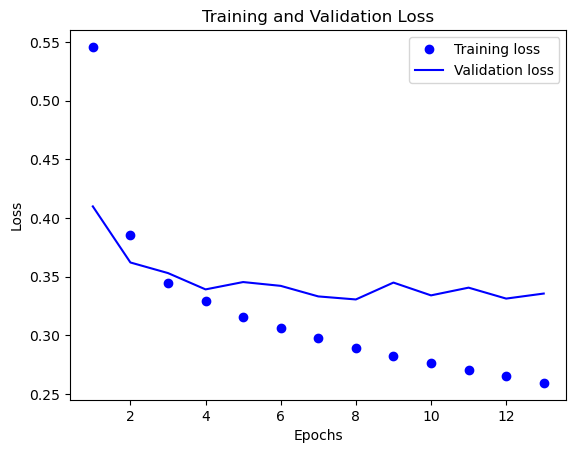

In [56]:
# 3_1 LSTM_CNN Random Embedding 모델 Loss 시각화

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('3_1 LSTM_CNN Random Embedding Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

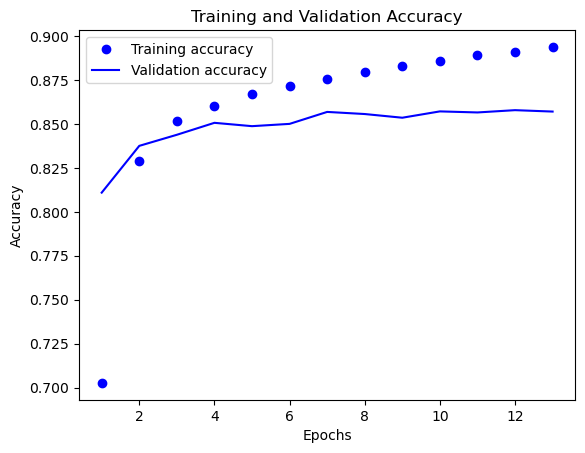

In [57]:
# 3_1 LSTM_CNN Random Embedding 모델 Accuracy 시각화

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('3_1 LSTM_CNN Random Embedding Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 9) 3_2 LSTM_CNN Word2vec Embedding 모델 실험

In [ ]:
# 9.1) 3_2 LSTM_CNN Word2vec Embedding 변수 설정 및 모델 학습

In [71]:
# 3_2 LSTM_CNN Word2vec Embedding 모델 학습

import torch
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티
import numpy as np
from tqdm import tqdm  # tqdm 라이브러리 import
import numpy as np

# 조기 종료 관련 하이퍼파라미터
patience = 5          # 검증 손실이 5번 연속으로 개선되지 않으면 훈련 중단
min_delta = 0.0001    # 최소한 이 값 이상 손실이 감소해야 개선으로 인정

best_loss = np.Inf    # 초기 최저 손실값 설정
patience_counter = 0  # 손실 개선 실패 횟수 카운터

# 모델 인스턴스화를 위한 변수 설정
# 이전 실험들과 일관성을 유지하거나 새로운 하이퍼파라미터를 설정한다.
vocab_size = 10000 
word_vector_dim = 100  # Word2Vec 임베딩을 위해 100으로 설정 (랜덤 실험 시에는 16)
max_length = 41
hidden_dim = 128  # LSTM의 은닉 상태 차원
num_layers = 2   # LSTM 레이어 수
dropout = 0.5  # 드롭아웃 확률
bidirectional = True # LSTM 양방향 설정
filter_sizes = [2, 3, 4] # CNN 필터 크기



# 📝 아래에 2_2에서 가져온 Word2Vec 임베딩 행렬 생성 코드를 추가합니다.

# Word2Vec 모델 로드 및 임베딩 행렬 생성
# 🚨 word_to_index 변수가 사전에 정의되어 있어야 함
word2vec_file_path = os.path.join(os.getenv('HOME'), 'work/sentiment_classification/data/word2vec_ko.model')
word2vec_ko = Word2Vec.load(word2vec_file_path)

# Word2Vec으로 채워진 임베딩 행렬 생성
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 100차원으로 초기화
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec_ko.wv:
        embedding_matrix[i] = word2vec_ko.wv[index_to_word[i]]

# ✨ 수정 부분: 생성된 임베딩 행렬의 차원을 즉시 확인
print(f"생성된 embedding_matrix의 차원: {embedding_matrix.shape}")

# 모델 인스턴스화
model_lstm_cnn_word2vec = SentenceClassifier_LstmCnn(
    embedding_matrix=embedding_matrix, 
    hidden_dim=hidden_dim, 
    num_layers=num_layers, 
    dropout=dropout, 
    bidirectional=bidirectional, 
    filter_sizes=filter_sizes, 
    max_length=max_length
)

# 1. 모델 임베딩 초기화 (Word2Vec 사용 시)
# 모델의 임베딩 레이어를 사전 학습된 Word2Vec 벡터로 덮어씌운다.

model_lstm_cnn_word2vec.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))


# ✨ 수정 부분: 모델의 임베딩 레이어 차원을 즉시 확인
print(f"모델 임베딩 레이어의 가중치 차원: {model_lstm_cnn_word2vec.embedding.weight.shape}")


# 2. 옵티마이저와 손실 함수 설정
# Adam 최적화 도구와 이진 분류에 적합한 BCELoss 손실 함수를 사용한다.
optimizer = optim.Adam(model_lstm_cnn_word2vec.parameters())
loss_fn = torch.nn.BCELoss()

# 3. 데이터 로더 준비
# 훈련 및 검증 데이터를 텐서로 변환하고 데이터셋, 데이터로더를 생성한다.
partial_X_train_tensor = partial_X_train.detach().clone().to(torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

X_val_tensor = X_val.detach().clone().to(torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_X_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []    # 에포크별 검증 손실을 저장할 리스트
train_accs = []    # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []      # 에포크별 검증 정확도를 저장할 리스트

# 4. 모델 훈련 및 검증 루프
for epoch in range(epochs):
    # 훈련 단계 시작
    model_lstm_cnn_word2vec.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화
        outputs = model_lstm_cnn_word2vec(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # 검증 단계 시작
    model_lstm_cnn_word2vec.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # 기울기 계산 비활성화 (메모리 절약, 속도 향상)
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
            outputs = model_lstm_cnn_word2vec(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)
    
    val_loss = val_losses[-1] # 현재 에포크의 검증 손실

    # 손실 개선 여부 확인
    if val_loss < best_loss - min_delta:
        best_loss = val_loss
        patience_counter = 0
        # 최적의 모델 가중치 저장
        torch.save(model_lstm_cnn_word2vec.state_dict(), 'model_lstm_cnn_word2vec.pth')
        print(f"Validation loss improved. Saving model weights...")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

    # 조기 종료 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
    # 에포크별 결과 출력ㄴ
    print(f"Epoch {epoch+1}/{epochs} - "
          f"T_Loss: {train_losses[-1]:.4f}, T_Acc: {train_accs[-1]:.4f} - "
          f"V_Loss: {val_losses[-1]:.4f}, V_Acc: {val_accs[-1]:.4f}")

생성된 embedding_matrix의 차원: (10000, 100)
모델 임베딩 레이어의 가중치 차원: torch.Size([10000, 100])


Epoch 1/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Validation loss improved. Saving model weights...
Epoch 1/30 - T_Loss: 0.4452, T_Acc: 0.7890 - V_Loss: 0.3531, V_Acc: 0.8448


Epoch 2/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Validation loss improved. Saving model weights...
Epoch 2/30 - T_Loss: 0.3332, T_Acc: 0.8555 - V_Loss: 0.3215, V_Acc: 0.8568


Epoch 3/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Validation loss improved. Saving model weights...
Epoch 3/30 - T_Loss: 0.2935, T_Acc: 0.8751 - V_Loss: 0.3111, V_Acc: 0.8637


Epoch 4/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Validation loss improved. Saving model weights...
Epoch 4/30 - T_Loss: 0.2671, T_Acc: 0.8890 - V_Loss: 0.3063, V_Acc: 0.8650


Epoch 5/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Validation loss did not improve. Patience counter: 1/5
Epoch 5/30 - T_Loss: 0.2457, T_Acc: 0.8990 - V_Loss: 0.3215, V_Acc: 0.8727


Epoch 6/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Validation loss did not improve. Patience counter: 2/5
Epoch 6/30 - T_Loss: 0.2235, T_Acc: 0.9090 - V_Loss: 0.3112, V_Acc: 0.8647


Epoch 7/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Validation loss did not improve. Patience counter: 3/5
Epoch 7/30 - T_Loss: 0.2022, T_Acc: 0.9186 - V_Loss: 0.3315, V_Acc: 0.8697


Epoch 8/30 [Validation]: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Validation loss did not improve. Patience counter: 4/5
Epoch 8/30 - T_Loss: 0.1840, T_Acc: 0.9275 - V_Loss: 0.3521, V_Acc: 0.8629


Epoch 9/30 [Validation]: 100%|██████████| 20/20 [00:09<00:00,  2.01it/s]

Validation loss did not improve. Patience counter: 5/5
Early stopping triggered after 9 epochs.


In [72]:
# 3_2 LSTM_CNN Word2vec Embedding 파일 저장
word2vec_file_path = 'model_lstm_cnn_word2vec.txt'

# 모델의 임베딩 가중치와 단어-인덱스 매핑 준비
# 1. 모델 변수명을 'model_lstm_cnn_word2vec'로 수정
vectors = model_lstm_cnn_word2vec.embedding.weight.detach().cpu().numpy()

# 2. 모델 훈련 시 사용했던 실제 'word_to_index' 딕셔너리를 활용하여
#    'index_to_word' 딕셔너리를 생성합니다.
#    (이 부분은 실제 훈련 코드에 있는 'word_to_index' 변수명으로 교체해야 합니다.)
#    예시: word_to_index = {'<pad>': 0, '<unk>': 1, '영화': 2, ...}
#    - word_to_index 변수가 없으면 이 코드는 에러를 발생시킵니다.
index_to_word = {index: word for word, index in word_to_index.items()}


# 파일에 쓰기
with open(word2vec_file_path, 'w') as f:
    # 1. 파일의 첫 줄에 '전체 단어 수', '벡터 차원'을 기록합니다.
    #    gensim이 이 정보를 보고 파일 형식을 판단합니다.
    vocab_size, word_vector_dim = vectors.shape
    f.write(f'{vocab_size} {word_vector_dim}\n')
    
    # 2. 각 단어의 벡터 값을 공백으로 구분하여 한 줄씩 기록합니다.
    for i in range(vocab_size):
        # 3. index_to_word.get(i, '<unk>')를 사용하여 없는 인덱스도 안전하게 처리
        word = index_to_word.get(i, '<unk>')
        vector_str = ' '.join(map(str, vectors[i, :]))
        f.write(f'{word} {vector_str}\n')

print(f"'{word2vec_file_path}' 파일에 임베딩 가중치가 저장되었습니다.")

'model_lstm_cnn_word2vec.txt' 파일에 임베딩 가중치가 저장되었습니다.


In [73]:
# 3_2 LSTM_CNN Word2vec Embedding 학습된 모델 테스트 

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_lstm_cnn_word2vec.load_state_dict(torch.load('model_lstm_cnn_word2vec.pth'))
model_lstm_cnn_word2vec.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm_cnn_word2vec(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3102, Test Accuracy: 0.8674


In [74]:
# 9.2) 3_2 LSTM_CNN Word2vec Embedding 모델 Loss, Accuracy 그래프 시각화

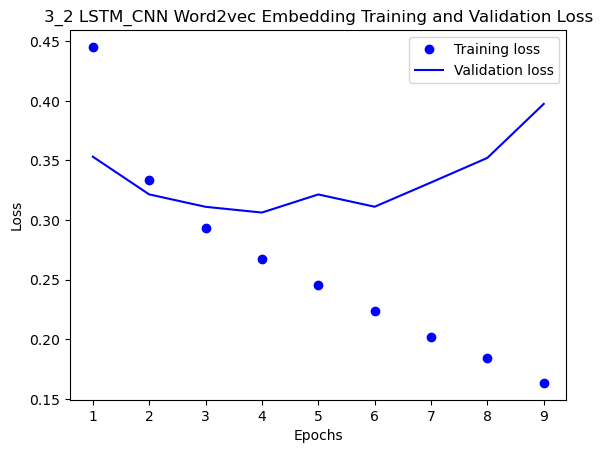

In [75]:
# 3_2 LSTM_CNN Word2vec Embedding 모델 Loss 시각화

import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('3_2 LSTM_CNN Word2vec Embedding Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

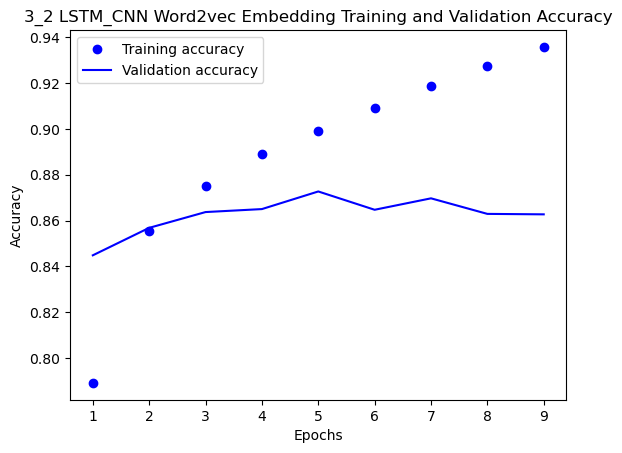

In [76]:
# 3_2 LSTM_CNN Word2vec Embedding 모델 Accuracy 시각화

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('3_2 LSTM_CNN Word2vec Embedding Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
#10) 임베딩 분석

In [97]:
# 6종 임배딩 비교
#1. 코드 블록 제목: 6가지 모델 임베딩 파일 유사 단어 비교 (개선)
# gensim과 OS 관련 라이브러리 임포트
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 2. 파일 경로 및 설정
# 역할: 임베딩 파일들이 저장된 기본 경로를 설정
# 목적: 모든 파일 경로를 간편하게 관리하기 위함입니다.
base_path = os.path.join(os.getenv('HOME'), 'work', 'workplace', 'AIFFEL_quest_rs', 'Exploration', 'Quest05', 'Mecab-ko-for-Google-Colab') + os.sep
# 역할: 비교할 6가지 임베딩 파일 목록을 리스트로 정의
# 목적: 반복문을 통해 각 파일을 순차적으로 처리하기 위함입니다.
embedding_files = [
    'model_lstm_random.txt',
    'model_lstm_word2vec.txt',
    'model_cnn_random.txt',
    'model_cnn_word2vec.txt',
    'model_lstm_cnn_random.txt',
    'model_lstm_cnn_word2vec.txt'
]
# 역할: 유사 단어를 찾을 대상 단어 목록을 정의
# 목적: 각 모델에서 동일한 단어들에 대한 유사 단어를 비교하기 위함입니다.
target_words = ['재미', '취향', '추천', '영화', '배우', '음악']

# 3. 임베딩 파일 로드
# 역할: 로드된 gensim 모델들을 저장할 딕셔너리 초기화
# 목적: 파일명(키)과 gensim 모델 객체(값)를 연결하여 편리하게 사용하기 위함입니다.
word_vectors_models = {}
print("--- 임베딩 파일 로드 시작 ---")
# 역할: embedding_files 리스트를 순회
# 목적: 6개의 파일을 하나씩 로드하고 딕셔너리에 저장합니다.
for filename in embedding_files:
    file_path = base_path + filename
    try:
        # 역할: gensim load_word2vec_format 함수를 사용해 파일을 로드
        # 목적: 텍스트 형식으로 저장된 임베딩 파일을 gensim 객체로 변환합니다.
        word_vectors = Word2VecKeyedVectors.load_word2vec_format(file_path, binary=False)
        word_vectors_models[filename] = word_vectors
        print(f"'{filename}' 로드 완료.")
    except FileNotFoundError:
        # 역할: 파일이 존재하지 않을 경우 에러를 출력하고 다음 파일로 넘어감
        # 목적: 파일 경로 오류로 인해 프로그램이 중단되는 것을 방지합니다.
        print(f"오류: '{filename}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

# 4. 유사 단어 비교 및 결과 출력
print("\n--- 유사 단어 비교 시작 ---")
# 역할: target_words 리스트를 순회
# 목적: 각 단어에 대해 모든 모델에서 유사 단어를 찾습니다.
for word in target_words:
    print(f"\n==================== 단어: '{word}' ====================")
    # 역할: word_vectors_models 딕셔너리를 순회
    # 목적: 모든 로드된 모델에 대해 유사 단어를 찾습니다.
    for model_name, model in word_vectors_models.items():
        # 역할: 현재 단어가 모델의 어휘 사전에 있는지 확인
        # 목적: 사전에 없는 단어로 유사 단어를 찾으려 할 경우 에러가 나는 것을 방지합니다.
        if word in model:
            # 역할: gensim의 similar_by_word 함수를 사용해 유사 단어를 찾아 출력
            # 목적: 각 모델이 생각하는 'word'와 가장 비슷한 단어들을 보여줍니다.
            print(f"[{model_name}] 유사 단어:")
            similar_words = model.similar_by_word(word, topn=5)
            # 역할: 찾은 유사 단어를 보기 좋게 출력
            # 목적: 각 결과가 어떤 단어인지, 유사도 점수는 얼마인지 명확하게 표시합니다.
            for similar_word, score in similar_words:
                print(f"  - {similar_word} (유사도: {score:.4f})")
        else:
            # 역할: 단어가 사전에 없을 경우 메시지 출력
            # 목적: 해당 모델이 이 단어를 학습하지 못했음을 알려줍니다.
            print(f"[{model_name}] 사전에 '{word}' 단어가 없습니다.")

--- 임베딩 파일 로드 시작 ---
'model_lstm_random.txt' 로드 완료.
'model_lstm_word2vec.txt' 로드 완료.
'model_cnn_random.txt' 로드 완료.
'model_cnn_word2vec.txt' 로드 완료.
'model_lstm_cnn_random.txt' 로드 완료.
'model_lstm_cnn_word2vec.txt' 로드 완료.

--- 유사 단어 비교 시작 ---

==================== 단어: '재미' ====================
[model_lstm_random.txt] 유사 단어:
  - 각성 (유사도: 0.8069)
  - 아이디 (유사도: 0.8042)
  - 리차드 (유사도: 0.7559)
  - 격투기 (유사도: 0.7208)
  - 동포 (유사도: 0.7163)
[model_lstm_word2vec.txt] 유사 단어:
  - 흥미 (유사도: 0.6045)
  - 유머 (유사도: 0.5922)
  - 취미 (유사도: 0.5863)
  - 묘미 (유사도: 0.5827)
  - 이야기 (유사도: 0.5700)
[model_cnn_random.txt] 유사 단어:
  - 졸라 (유사도: 0.9201)
  - 님 (유사도: 0.9183)
  - 비씨 (유사도: 0.9035)
  - 소위 (유사도: 0.9016)
  - 밥상 (유사도: 0.8997)
[model_cnn_word2vec.txt] 유사 단어:
  - 흥미 (유사도: 0.5848)
  - 취미 (유사도: 0.5770)
  - 보람 (유사도: 0.5738)
  - 유머 (유사도: 0.5722)
  - 공감 (유사도: 0.5504)
[model_lstm_cnn_random.txt] 유사 단어:
  - 아시아 (유사도: 0.9063)
  - 끝판 (유사도: 0.8914)
  - 방화 (유사도: 0.8810)
  - 고소 (유사도: 0.8788)
  - 본다는 (유사도: 0.8776)
[model_lstm_cnn_w

/opt/conda/lib/python3.12/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


--- lstm_random 임베딩 가중치 추출 중 ---
lstm_random 임베딩 가중치 추출 완료. Shape: (10000, 16)
--- lstm_word2vec 임베딩 가중치 추출 중 ---
lstm_word2vec 임베딩 가중치 추출 완료. Shape: (10000, 100)
--- cnn_random 임베딩 가중치 추출 중 ---
cnn_random 임베딩 가중치 추출 완료. Shape: (10000, 16)
--- cnn_word2vec 임베딩 가중치 추출 중 ---
cnn_word2vec 임베딩 가중치 추출 완료. Shape: (10000, 100)
--- lstm_cnn_random 임베딩 가중치 추출 중 ---
lstm_cnn_random 임베딩 가중치 추출 완료. Shape: (10000, 16)
--- lstm_cnn_word2vec 임베딩 가중치 추출 중 ---
lstm_cnn_word2vec 임베딩 가중치 추출 완료. Shape: (10000, 100)

### 임베딩 가중치 간의 코사인 유사도 비교 ###
                   lstm_random  lstm_word2vec  cnn_random  cnn_word2vec  \
lstm_random           1.000000       0.000915   -0.002211      0.007643   
lstm_word2vec         0.000915       1.000000   -0.038719      0.926673   
cnn_random           -0.002211      -0.038719    1.000000     -0.035036   
cnn_word2vec          0.007643       0.926673   -0.035036      1.000000   
lstm_cnn_random      -0.007816      -0.042637    0.733624     -0.039193   
lstm_cnn_word2vec 

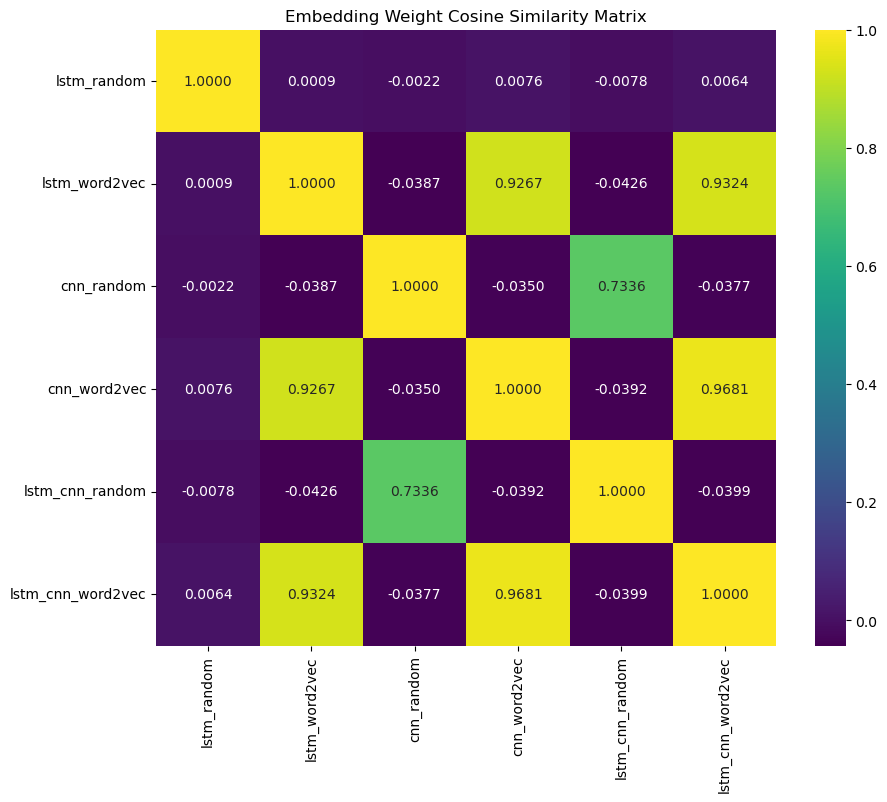


### 분석 결과 ###
- 각 행과 열은 모델의 임베딩 가중치를 나타냅니다.
- 히트맵의 값은 두 임베딩 가중치 벡터 간의 평균 코사인 유사도를 의미합니다.
- 값이 1에 가까울수록 두 임베딩 가중치가 매우 유사하다는 뜻입니다.
- Word2Vec 모델들 간의 유사도, Random 모델들 간의 유사도를 비교해보세요.
- 예를 들어, 'lstm_word2vec'과 'cnn_word2vec'의 유사도는 'lstm_random'과 'cnn_random'의 유사도와 어떻게 다른가요?


In [98]:
# 0. 라이브러리 및 모델 클래스 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM 모델 
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어를 워드 벡터로 변환하는 임베딩 레이어
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)  # 워드 벡터 시퀀스를 처리하는 LSTM 레이어
        self.fc1 = nn.Linear(8, 8)  # LSTM의 최종 출력을 받아서 처리하는 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력을 0과 1 사이의 값으로 만드는 두 번째 완전 연결 레이어

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 임베딩 레이어에 통과시켜 워드 벡터로 변환
        x, (hn, cn) = self.lstm(x)  # 임베딩 벡터 시퀀스를 LSTM에 통과
        x = x[:, -1, :]  # LSTM의 최종 시점(sequence의 마지막)의 은닉 상태를 가져옴
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 레이어에 통과시키고 ReLU 활성화 함수 적용
        x = torch.sigmoid(self.fc2(x))  # 두 번째 완전 연결 레이어에 통과시키고 시그모이드 활성화 함수 적용 (0~1 사이 값)
        return x  # 최종 출력값 반환



# Cnn 모델
class SentenceClassifier_Cnn(nn.Module):
    # 모델의 레이어(Layer)들을 정의하는 생성자
    def __init__(self, embedding_matrix, filter_sizes, max_length, dropout=0.5):
        super().__init__()  # nn.Module의 생성자 호출

        # 임베딩 레이어
        self.embedding = nn.Embedding(
            num_embeddings=embedding_matrix.shape[0],
            embedding_dim=embedding_matrix.shape[1]
        )
        # 외부에서 전달받은 행렬의 값을 임베딩 레이어의 가중치로 복사
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        # 임베딩 레이어의 차원(word_vector_dim) 추출
        embedding_dim = self.embedding.weight.shape[1]
        num_filters = 128  # out_channels 수를 128로 설정

        conv = []
        for size in filter_sizes:  # filter_sizes (예: [3, 4, 5])에 따라 여러 개의 CNN 필터를 만듦
            conv.append(
                nn.Sequential(  # 여러 레이어를 묶어서 하나의 모듈로 구성
                    nn.Conv1d(  # 1차원 컨볼루션 레이어
                        in_channels=embedding_dim,  # 입력 채널 수: 워드 벡터의 차원
                        out_channels=num_filters,  # 출력 채널 수: 각 필터에서 하나의 특징을 추출
                        kernel_size=size  # 필터의 크기 (ex: 3, 4, 5)
                    ),
                    nn.ReLU(),  # 비선형성을 추가하는 활성화 함수
                    nn.AdaptiveMaxPool1d(1),  # 최대 풀링으로 가장 중요한 특징 추출
                )
            )
        self.conv_filters = nn.ModuleList(conv)  # 여러 컨볼루션 모듈을 리스트 형태로 저장

        num_filters = 128
        output_size = num_filters * len(filter_sizes) # 128 * 3 = 384 # 필터의 개수가 최종 출력의 크기가 됨
        self.pre_classifier = nn.Linear(output_size, 64)  # 첫 번째 완전 연결 레이어
        self.dropout = nn.Dropout(dropout)  # 과적합을 방지하는 드롭아웃 레이어
        self.classifier = nn.Linear(64, 1)  # 최종 분류를 위한 완전 연결 레이어 (출력 1개)

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, inputs):
        embeddings = self.embedding(inputs)  # 입력(단어 인덱스)을 임베딩 레이어에 통과
        embeddings = embeddings.permute(0, 2, 1)  # Conv1d 입력에 맞게 차원 변경 (배치, 차원, 길이)

        conv_outputs = [conv(embeddings) for conv in self.conv_filters]  # 각 필터를 통과한 결과물을 리스트에 저장
        concat_outputs = torch.cat([conv.squeeze(-1) for conv in conv_outputs], dim=1)  # 필터 결과물을 하나로 합침

        logits = self.pre_classifier(concat_outputs)  # 첫 번째 완전 연결 레이어 통과
        logits = self.dropout(logits)  # 드롭아웃 적용
        logits = self.classifier(logits)  # 최종 분류 레이어 통과
        
        return torch.sigmoid(logits)  # 이진 분류를 위해 시그모이드 활성화 함수 적용




# lstm+cnn 모델
class SentenceClassifier_LstmCnn(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout, bidirectional, filter_sizes, max_length):
        super().__init__()

        # 1. 임베딩 레이어: 단어를 벡터로 변환
        self.embedding = nn.Embedding(
            num_embeddings=embedding_matrix.shape[0],
            embedding_dim=embedding_matrix.shape[1]
        )
        
          # 외부에서 전달받은 행렬의 값을 임베딩 레이어의 가중치로 복사
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        
        embedding_dim = self.embedding.weight.shape[1]
        # self.embedding.weight.requires_grad = True

        # 2. LSTM 레이어: 문장의 순차적인 흐름과 맥락을 학습
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True  # 입력 텐서의 첫 번째 차원이 배치 크기임을 명시
        )
        
        # LSTM의 출력 차원을 계산
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        num_filters = 128  # out_channels 수를 128로 설정
        
        # 3. CNN 필터들: LSTM 출력에서 특징을 추출
        conv = []
        for size in filter_sizes:
            conv.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=lstm_output_dim,  # LSTM의 출력을 입력으로 사용
                        out_channels=num_filters,
                        kernel_size=size
                    ),
                    nn.ReLU(),
                    nn.AdaptiveMaxPool1d(1),
                )
            )
        self.conv_filters = nn.ModuleList(conv)
        
        # 4. 분류기 레이어: 추출된 특징으로 최종 분류
        output_size = num_filters * len(filter_sizes) # 128 * 3 = 384

        self.pre_classifier = nn.Linear(output_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(64, 1)

    def forward(self, inputs):
        # (1) 임베딩 레이어 통과
        embeddings = self.embedding(inputs)  # [배치, 시퀀스 길이, 임베딩 차원]

        # (2) LSTM 레이어 통과
        lstm_output, (hidden, cell) = self.lstm(embeddings)
        # lstm_output: [배치, 시퀀스 길이, hidden_dim * 2 (양방향인 경우)]

        # (3) CNN 레이어 입력에 맞게 차원 변경
        # Conv1d를 위해 [배치, 채널 수, 시퀀스 길이] 형태로 변경
        lstm_output = lstm_output.permute(0, 2, 1)

        # (4) CNN 필터들 통과
        conv_outputs = [conv(lstm_output) for conv in self.conv_filters]
        concat_outputs = torch.cat([conv.squeeze(-1) for conv in conv_outputs], dim=1)

        # (5) 분류기 통과
        logits = self.pre_classifier(concat_outputs)
        logits = self.dropout(logits)
        logits = self.classifier(logits)

        # 최종 시그모이드 활성화 함수 적용
        return torch.sigmoid(logits)




# 1. 모델 파일 경로 및 설정 정보
base_path = os.path.join(os.getenv('HOME'), 'work', 'workplace', 'AIFFEL_quest_rs', 'Exploration', 'Quest05', 'Mecab-ko-for-Google-Colab') + os.sep
model_configs = {
    'lstm_random': {'path': base_path + 'model_lstm_random.pth', 'class': SentimentModel, 'params': {'vocab_size': 10000, 'word_vector_dim': 16}},
    'lstm_word2vec': {'path': base_path + 'model_lstm_word2vec.pth', 'class': SentimentModel, 'params': {'vocab_size': 10000, 'word_vector_dim': 100}},
    'cnn_random': {'path': base_path + 'model_cnn_random.pth', 'class': SentenceClassifier_Cnn, 'params': {'embedding_matrix': np.random.rand(10000, 16), 'filter_sizes': [2, 3, 4], 'max_length': 41, 'dropout': 0.5}},
    'cnn_word2vec': {'path': base_path + 'model_cnn_word2vec.pth', 'class': SentenceClassifier_Cnn, 'params': {'embedding_matrix': np.random.rand(10000, 100), 'filter_sizes': [2, 3, 4], 'max_length': 41, 'dropout': 0.5}},
    'lstm_cnn_random': {'path': base_path + 'model_lstm_cnn_random.pth', 'class': SentenceClassifier_LstmCnn, 'params': {'embedding_matrix': np.random.rand(10000, 16), 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5, 'bidirectional': True, 'filter_sizes': [2, 3, 4], 'max_length': 41}},
    'lstm_cnn_word2vec': {'path': base_path + 'model_lstm_cnn_word2vec.pth', 'class': SentenceClassifier_LstmCnn, 'params': {'embedding_matrix': np.random.rand(10000, 100), 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5, 'bidirectional': True, 'filter_sizes': [2, 3, 4], 'max_length': 41}}
}

# model_names와 embedding_weights 딕셔너리 초기화
model_names = list(model_configs.keys())
embedding_weights = {}
similarity_matrix = np.zeros((len(model_names), len(model_names)))

# 2. 각 모델 로드 및 임베딩 가중치 추출
for model_name, config in model_configs.items():
    print(f"--- {model_name} 임베딩 가중치 추출 중 ---")
    
    try:
        # 모델 인스턴스화
        model = config['class'](**config['params'])
        
        # 저장된 가중치 로드
        model.load_state_dict(torch.load(config['path']))
        
        # 임베딩 가중치 추출 및 저장
        # .detach().cpu().numpy()를 사용하여 텐서를 넘파이 배열로 변환
        embedding_weights[model_name] = model.embedding.weight.data.detach().cpu().numpy()
        
        print(f"{model_name} 임베딩 가중치 추출 완료. Shape: {embedding_weights[model_name].shape}")

    except FileNotFoundError:
        print(f"오류: {config['path']} 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    except Exception as e:
        print(f"오류: {model_name} 모델 로드 및 가중치 추출 실패 - {e}")

# 3. 임베딩 가중치 간의 유사도(코사인 유사도) 계산 및 비교
print("\n### 임베딩 가중치 간의 코사인 유사도 비교 ###")

# 모든 모델 쌍에 대한 유사도를 저장할 딕셔너리
def calculate_similarity(vec1, vec2):
    # 크기가 0인 벡터를 방지하기 위해 0 대신 작은 값(epsilon)을 더함
    norm1 = np.linalg.norm(vec1, axis=1, keepdims=True)
    norm2 = np.linalg.norm(vec2, axis=1, keepdims=True)

    # 크기가 0인 벡터가 있는지 확인
    if (norm1 == 0).any() or (norm2 == 0).any():
        return np.nan # 유사도 계산 불가

    vec1_norm = vec1 / norm1
    vec2_norm = vec2 / norm2
    
    similarity = np.mean(np.sum(vec1_norm * vec2_norm, axis=1))
    return similarity

# 기존 for 루프를 수정하여 함수 호출
for i, name1 in enumerate(model_names):
    for j, name2 in enumerate(model_names):
        # 딕셔너리에 키가 존재하는지 확인
        if name1 in embedding_weights and name2 in embedding_weights:
            dim1 = embedding_weights[name1].shape[1]
            dim2 = embedding_weights[name2].shape[1]
            min_dim = min(dim1, dim2)
            
            vec1 = embedding_weights[name1][:, :min_dim]
            vec2 = embedding_weights[name2][:, :min_dim]
            
            similarity_matrix[i, j] = calculate_similarity(vec1, vec2)
        else:
            similarity_matrix[i, j] = np.nan # 계산에 실패했음을 표시

# 4. 결과 시각화
similarity_df = pd.DataFrame(similarity_matrix, index=model_names, columns=model_names)
print(similarity_df)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='viridis', fmt=".4f")
plt.title('Embedding Weight Cosine Similarity Matrix')
plt.show()

# 5. 상세 분석
print("\n### 분석 결과 ###")
print("- 각 행과 열은 모델의 임베딩 가중치를 나타냅니다.")
print("- 히트맵의 값은 두 임베딩 가중치 벡터 간의 평균 코사인 유사도를 의미합니다.")
print("- 값이 1에 가까울수록 두 임베딩 가중치가 매우 유사하다는 뜻입니다.")
print("- Word2Vec 모델들 간의 유사도, Random 모델들 간의 유사도를 비교해보세요.")
print("- 예를 들어, 'lstm_word2vec'과 'cnn_word2vec'의 유사도는 'lstm_random'과 'cnn_random'의 유사도와 어떻게 다른가요?")

In [100]:
# 모델 임베딩 가중치 확인

print(embedding_weights['lstm_random'])
print(embedding_weights['lstm_word2vec'])
print(embedding_weights['cnn_random'])
print(embedding_weights['cnn_word2vec'])
print(embedding_weights['lstm_cnn_random'])
print(embedding_weights['lstm_cnn_word2vec'])

[[-0.89221436  0.5461508   1.8970548  ... -1.0821493   0.0147409
  -0.25613198]
 [ 0.9592525  -2.1962833  -0.24032348 ... -0.87276816 -2.2633724
   1.0769211 ]
 [ 0.21960175  0.13358347  1.1423271  ...  2.081694    1.1728971
  -1.1994025 ]
 ...
 [ 1.1861176   2.1259058  -2.3520658  ...  0.27365622 -0.6708065
   0.58210015]
 [ 0.8319667  -0.60065323 -0.1814634  ... -0.67760724 -0.38933098
  -0.21630338]
 [ 0.5812936  -0.3694407   0.49240908 ...  0.6489035   1.1139072
   1.0112278 ]]
[[ 0.58784235  0.8565811   1.0663953  ...  0.13730332  1.078225
   1.0153122 ]
 [ 0.9740779   0.50415283  0.17057924 ...  0.6720126   0.5940894
   0.5038497 ]
 [ 0.14625157  0.6354183   0.04701052 ...  0.13143106  0.48882276
   0.53698844]
 ...
 [-0.19477665  0.24431498  0.08055332 ...  0.15408053 -0.13544048
   0.2367771 ]
 [-1.4079916   1.0367842  -0.06548559 ... -1.1185404   0.72323465
  -1.9467291 ]
 [ 0.01352522  0.02242119 -0.12756261 ...  0.12165197 -0.07344235
   0.13692093]]
[[0.7292536  0.02363318 